# Lecture 21 - Markov Chain Monte Carlo I

## Objectives

+ Define the basics of Markov Chains (transition kernels, invariance, ergodicity, detailed balance condition).
+ Use the Metropolis algorithm (the simplest Markov Chain Monte Carlo (MCMC) algorithm) to sample from an arbitrary probability density known up to a normalization constant.
+ Learn how to diagnose the convergence of MCMC algorithms by monitoring the acceptance rate, and autocorrelation.
+ Use MCMC to calibrate the reaction kinetics problem using the Bayesian formulation.

## Readings

+ Chapter 11 of Bishop.
+ These notes.

## Attention

The MCMC results below are not correct! You are supposed to follow the discussion and the answer questions to get the correct results!

In [1]:
import numpy as np
import math
import scipy.stats as st
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')
import design
import warnings
warnings.filterwarnings('ignore')

## Problem Definition

We have seen that the Bayesian formulation of inverse problems results in intractable posterior distributions.
In particular, these posteriors are known only up to a normalization constant.
In the next series of lectures, we are going to develop methodologies that allows us to sample from these distributions.
The most celebrated of these methodologies is Markov Chain Monte Carlo (MCMC) which has at its core the Metropolis algorithms.
It is a long way to go, but we can state right away the problem definition and what we are set out to do.

Without loss of generality, let $X\in\mathcal{X}\subset\mathbb{R}^d$ be random variable with an arbitrary probability density, say $\pi(x)$ known up to a normalization constant.
That is, we have that:
$$
\pi(x) = \frac{h(x)}{Z},
$$
where $h(x)$ is a known function that we can evaluate at will, but $Z$ is not known.
Our goal is to generate samples from $\pi(x)$, by only evaluating $h(x)$.
The revolutionary idea of Metropolis was to construct a stochastic process using only $h(x)$ samples from which resemble (in some way we will specify below) samples from $\pi(x)$.
To understand the details, we will have to introduce some key concepts.

# Markov Chains

## Definition
Let $X_n, n=1,2,\dots$ be a stochastic process taking values in $\mathcal{X}\subset\mathbb{R}^d$ whcih could either be discrete or continuous.
We will refer to $n$ as the *time step*.
We say that this stochastic process is a *Markov chain* if the evolution of $X_{n+1}$ depends only on the value of $X_n$ and not on all the history of the process.
Let us define this a little bit more rigorously.

Let $x_1,\dots,x_n\in\mathcal{X}$ be the observed values of the process up to $n$-th time step.
The Markov property can now be expressed as:
$$
p(X_{n+1}=x_{n+1}|X_1=x_1,\dots,X_n=x_n) = p(X_{n+1}=x_{n+1}|X_n=x_n).
$$
If there is no ambiguity, we will be simplifying the notation by dropping the capital letters.
That is, we will be writting:
$$
p(x_{n+1}|x_1,\dots,x_n) = p(x_{n+1}|x_n).
$$
To simplify things even further, we will also use the collective notation:
$$
x_{1:n} = (x_1,\dots,x_n)\in\mathcal{X}^n.
$$
With this notation, we can re-write the Markov property in even simpler terms:
$$
p(x_{n+1}|x_{1:n}) = p(x_{n+1}|x_n).
$$

## The joint distribution of a Markov chain
The *joint distribution* is defined as:
$$
p(x_{1:n}) := P(X_1=x_1,\dots,X_n=x_n).
$$
If $X_n$ is a Markov chain, then we simply have:
$$
p(x_{1:n}) = p(x_1)p(x_2|x_1)\dots p(x_n|x_{n-1}),
$$
or
$$
p(x_{1:n}) = p(x_1)\prod_{t=2}^np(x_t|x_{t-1}).
$$
So, we see that we know the joint distribution of a Markov chain if we know the probability of hoping from one state to the next.
This propability is known as the transition kernel of the Markov chain.

## Transition Kernel
To describe a Markov chain, we only need to know the *transition kernel*.
The transition kernel gives the probability of moving from one state to any other at a given step.
Mathematically, the transition kernel of the $n$-th step is the function:
$$
T_n:\mathcal{X}\times \mathcal{X}\rightarrow \mathbb{R}_+,
$$
defined by:
$$
T_n(x_n, x_{n+1}) = P(X_{n+1}=x_{n+1}|X_n=x_n).
$$
In words, $T_n(x_n, x_{n+1})$ is the probability that at step $n$ we jump from state $x_n$ to to state $x_{n+1}$.

Please, note that the transition kernel, in general, depends on the time step $n$.
We say that the Markov chain is *stationary*, if the transition kernel does not depend on $n$, i.e., if
$$
T_n(x_n, x_{n+1}) = T(x_n,x_{n+1}).
$$
**From now on, we will only consider stationary Markov chains.**
For stationary Markov chains, and when there is now ambiguity, we will be writing:
$$
T(x_n,x_{n+1}) = p(x_{n+1}|x_n).
$$

## Example 1: Random walk in 1D.

Random walk in 1D is one of the most basic Markov chains.
It will be the building block for the Metropolis algorithm.
The *state space* is:
$$
\mathcal{X} = \mathbb{R}.
$$
The *transition kernel* is:
$$
p(x_{n+1}|x_n) \equiv T(x_{n},x_{n+1}) := \mathcal{N}\left(x_{n+1}|x_n,\sigma^2\right) = \left(2\pi\sigma^2\right)^{-\frac{1}{2}}\exp\left\{-\frac{\left(x_{n+1}-x_n\right)^2}{2\sigma^2}\right\},
$$
for some parameter $\sigma>0$.
An alternative way of writing the same thing is:
$$
X_{n+1} = X_n + \sigma Z_n,
$$
where $Z_1,\dots,Z_n\sim \mathcal{N}(0,1)$ independent random variables.

Let's visualize it:

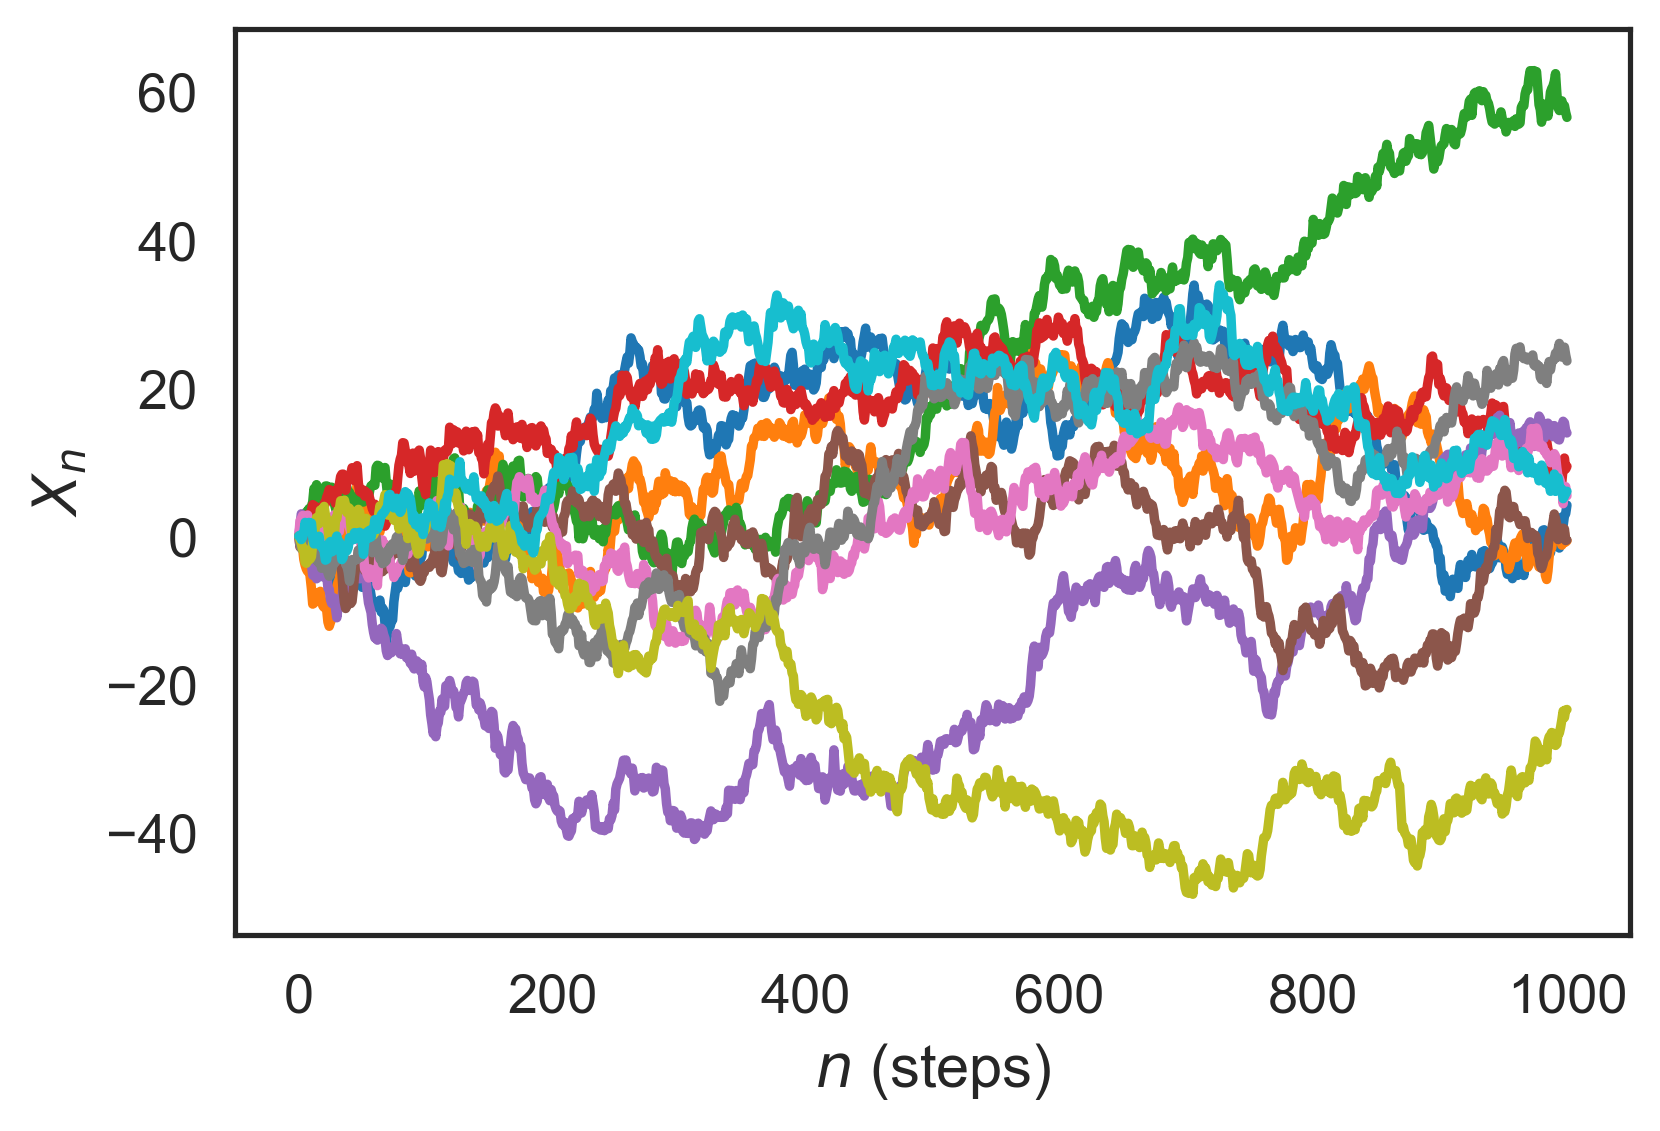

In [2]:
# Pick a starting point for your random walk
x0 = 0.
# Pick a standard deviation for your random walk
sigma = 1
# Pick the number of steps you want to simulate
n = 1000
# How many different sample paths of the process do you want to simulate
n_paths = 10
# We will be plotting in here:
fig, ax = plt.subplots()
# Loop over the paths
for _ in range(n_paths):
    # Simulate a single path
    X = np.ndarray((n + 1,))
    X[0] = x0
    for t in range(1, n + 1):
        Zt = np.random.randn()
        X[t] = X[t-1] + sigma * Zt
    # Let's plot it
    ax.plot(range(n+1), X)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$X_n$');

### Questions
+ Increase the number of steps $n$ from 1,000 to 10,000 to 100,000. Run it a couple of times for each case. What do you observe?
+ Get the number of steps $n$ down to 1,000. Increase $\sigma$ to 0.1 to 1. What do you observe for the values of $X$?
+ Plot ten different sample path from the random walk process.

## Example 2: Random Walk in Higher-dimensions.

The random walk can be generalized to arbitrary dimensions.
The *state space* is:
$$
\mathcal{X} = \mathbb{R}^d.
$$
The *transition kernel* is:
$$
p(x_{n+1}|x_n) \equiv T(x_{n},x_{n+1}) := \mathcal{N}\left(x_{n+1}|x_n,\Sigma\right) = \left(2\pi\right)^{-\frac{d}{2}}|\Sigma|^{-\frac{1}{2}}\exp\left\{-\frac{1}{2}(x_{n+1}-x_n)^T\Sigma^{-1}(x_{n+1}-x_n)\right\},
$$
for some positive definite covariance matrix $\Sigma\in\mathbb{R}^{d\times d}$.

An alternative way of writing the same thing is:
$$
X_{n+1} = X_n + A Z_n,
$$
where $Z_1,\dots,Z_n\sim \mathcal{N}(0,I_d)$ independent random vectors, and $A\in\mathbb{R}^{d\times d}$ is a square root of $\Sigma$, e.g., the Cholesky decomposition.

Let's visualize it for two dimensions:

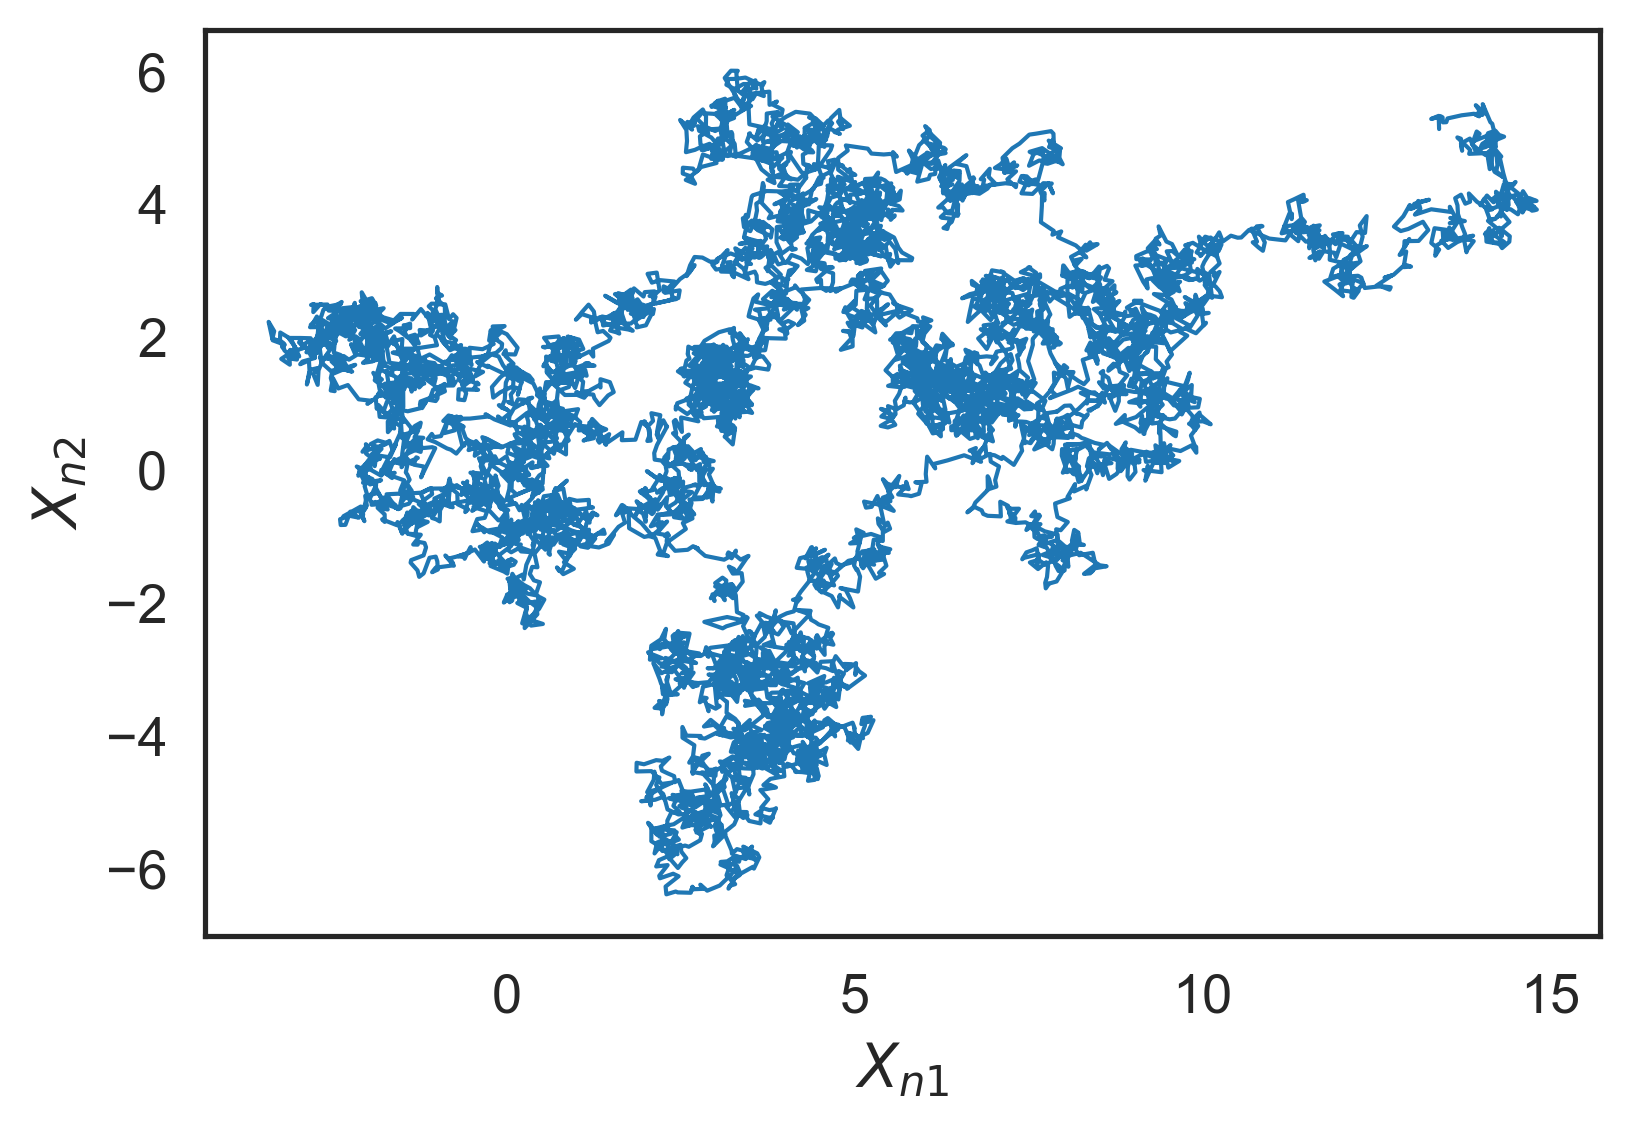

In [3]:
# Pick a starting point for your random walk
x0 = np.zeros((2,))
# Pick a standard deviation for your random walk
sigma1 = 0.1
sigma2 = 0.1
Sigma = np.diag([sigma1 ** 2, sigma2 ** 2])
A = np.linalg.cholesky(Sigma)
# Pick the number of steps you want to simulate
n = 10000
# How many different sample paths of the process do you want to simulate
n_paths = 1
# We will be plotting in here:
fig, ax = plt.subplots()
# Loop over the paths
for _ in range(n_paths):
    # Simulate a single path
    X = np.ndarray((n + 1, 2))
    X[0, :] = x0
    for t in range(1, n + 1):
        Zt = np.random.randn(2)
        X[t, :] = X[t-1] + np.dot(A, Zt)
    # Let's plot it
    ax.plot(X[:, 0], X[:, 1], lw=1)
ax.set_xlabel('$X_{n1}$')
ax.set_ylabel('$X_{n2}$');

### Questions
+ Increase the number of steps $n$ from 1,000 to 10,000 to 100,000. Run it a couple of times for each case. What do you observe?
+ Get the number of steps $n$ down to 1,000. Increase $\sigma$ to 0.1 to 1. What do you observe for the values of $X$?
+ Plot ten different sample path from the random walk process.

## Invariant Distributions

Let $X_1,X_2,\dots$ be a Markov chain with transition kernel $T(x,x')$ and $\pi(x)$ be a probability density.
We say that the Markov chain leaves $\pi(x)$ *invariant* if:
$$
\pi(x) = \int \pi(x')T(x',x)dx'.
$$
In words, $\pi(x)$ is invariant if when you start from a sample from it and you follow the Markov chain you get a sample from it.

Invariance is one of the key requirements of a working MCMC algorithm.
Whatever you do, the chain you construct must be invariant with respect to the distribution from which you want to sample.
If you manage to do that, then once you get one sample from your distribution, you can get as many as you want by simply following the transition kernel.



## The Detailed Balance Condition
Checking invariance is not trivial for a generic Markov chain.
However, there is a sufficient condition that guarantees invariance.
This condition is known as the *detailed balance condition* and it is:
$$
\pi(x)T(x,x') = \pi(x')T(x',x).
$$
In words, a Markov chain that satisfies the detailed balance condition is *reversible* in the following sense.
The probability of sampling an $x$ and transitioning to $x'$ is the same as the probability of doing the reverse.

If the detailed balance condition is satisfied, then $\pi(x)$ is an invariant distribution:
$$
\int \pi(x')T(x',x)dx' = \int \pi(x)T(x,x')dx' = \pi(x)\int T(x,x')dx' = \pi(x),
$$
since
$$
\int T(x,x') dx' = \int p(x'|x)dx' = 1.
$$
The reverse does not necessarily hold.
The key idea of Metropolis was to construct a Markov chain that satisfies the detailed balance condition for the distribution you are interested in.

## Ergodicity

A Markov chain may have no invariant distribution (e.g., the random walk does not have an invariant distribution), one, or more than one.
To guarantee uniqueness of the invariant distribution, need *ergodicity*.
To define ergodicity precicely for contiuous Markov chains, we need a little bit of notation.
In words, ergodicity requires that the random variable $X_n$ converges in distribution to $\pi(x)$ irrespective of the starting point.
Obviously, this is not easy to show for a generic Markov chain.
Fortunately, we know that a Markov chain is ergodic if:

+ it is *aperiodic* (i.e., it does not return to the same state at fixed intervals)
+ it is *positive recurrent* (i.e., the expected number of steps for returning to the same state is finite).

## Equilibrium Distribution
If a Markov chain is ergodic and it has an invariant distribution, then that invariant distribution is unique and it is called the *equilibrium distribution*.
The Metropolis algorithms constructs a Markov chain that has a desired equilibrium distribution.

# The Metropolis Algorithm

Now, let's get back to the initial problem of sampling from:
$$
\pi(x) = \frac{h(x)}{Z},
$$
without knowing $Z$.
In 1953, Metropolis et al. demonstrated how we can construct a Markov chain with $\pi(x)$ as the equilibrium density.
The algorithm is based on biasing an underlying symmetric, stationary Markov chain.
Let $T(x,x')$ be the transition kernel of this underlying Markov chain (also called the *proposal distribution*.
The transition kernel must be symmetric, i.e.,
$$
T(x,x') = T(x',x).
$$
A very common choice of the proposal distribution is the random walk transition kernel:
$$
T(x,x') = \mathcal{N}(x'|x, \Sigma).
$$
However, this is just one possibility.
Once we have pick a proposal, we construct the desired Markov chain as follows:

+ **Initialization:** Pick an arbitrary starting point $x_0$.
+ For each time step $n$:
    - **Generation:** Sample a candidate $x$ from $T(x_n, x)$.
    - **Calculation:** Calculate the *acceptance ratio*:
    $$
    \alpha(x_n, x) = \min\left\{1, \frac{h(x)}{h(x_n)}\right\}.
    $$
    This is the only place where you may need to evaluate the underlying model.
    - **Accept/Reject:**
        - Generate a uniform number $u\sim \mathcal{U}([0,1])$.
        - If $u\le \alpha$, *accept* and set $x_{n+1}=x$.
        - If $u > \alpha$, *reject* ad set $x_{n+1} = x_n$.
        
Let's test it before we prove that it works.
Here is a generic implementation. Note that we are working with the $\log h(x)$ for numerical stability.

In [4]:
def rwmetropolis(x0, log_h, n, sigma, args=()):
    """
    Random walk metropolis.
    
    :param x0:     The initial point (numpy array).
    :param log_h:  The logartihm of the function that is proportional to the density you want to sample from (function).
    :param n:      The maximum number of steps you want to take.
    :param sigma:  The standard deviation of the random walk proposal.
    :param args:   Any parameters to log_h.
    
    :returns:  X, acceptance_rate
    """
    x0 = np.array(x0)
    assert x0.ndim == 1
    # Dimensionality of space
    d = x0.shape[0]
    # A place to store the samples
    X = np.ndarray((n + 1, d))
    X[0, :] = x0
    # Previous value of log(h(x))
    log_h_p = log_h(x0, *args)
    # Keep track of how many samples are accepted
    count_accepted = 0
    # Start the simulation
    for t in range(1, n + 1):
        # Generation
        x = X[t - 1, :] + sigma * np.random.randn(d)
        # Calculation
        log_h_c = log_h(x, *args) # Current value of log(h(x))
        alpha = min(1, np.exp(log_h_c - log_h_p))
        # Accept/Reject
        u = np.random.rand()
        if u <= alpha: # Accept
            X[t, :] = x
            log_h_p = log_h_c
            count_accepted += 1
        else:          # Reject
            X[t, :] = X[t - 1, :]
    # Empirical acceptance rate
    acceptance_rate = count_accepted / (1. * n)
    return X, acceptance_rate

# Example 3: Sampling from an Exponential using Random Walk Metropolis

Let's take $\mathcal{X}=(0,\infty)$ and:
$$
\pi(x) \propto e^{-10x}.
$$
This is proportional to an exponential density with rate $\lambda=10$.
Of course, we know that the normalization constant is $Z=1/10$, but we are not going to use it.
As a proposal distribution, we will use a simple random walk:
$$
T(x_n,x) = \mathcal{N}(x|x_n, \sigma^2),
$$
and we will just pick $\sigma>0$ by hand.
Here we go:

In [5]:
# A function proportional to the logarithm of the density from which you wish to sample.
# (We always work with the log for numerical stability)
def log_h(x):
    if x[0] < 0:
        return -1e99 # Negative values are not allowed - Give back something very negative
    return -10. * x[0]  # The log of h(x)

# Initialiazation:
x0 = np.array([10.])
# Parameters of the proposal:
sigma = 1.
# Number of steps
n = 10000

X, acceptance_rate = rwmetropolis(x0, log_h, n, sigma)

print 'Acceptance rate: %1.2f' % acceptance_rate

Acceptance rate: 0.08


The acceptance rate gives the percentage of steps with an accepted move.
For a local proposal distribution (like our random walk above) we should struggle to keep the acceptance rate between 0.2 and 0.6. This can be done by adjusting the size of the steps that we propose.
In general:
+ If the acceptance rate is too small, then our chain makes too ambitious moves.
+ If the acceptance rate is too big, then our chain is not ambitious enough.

## Questions

+ Choose $\sigma$ so that you make the acceptance rate around $0.25$.

Let's visualize the chain:

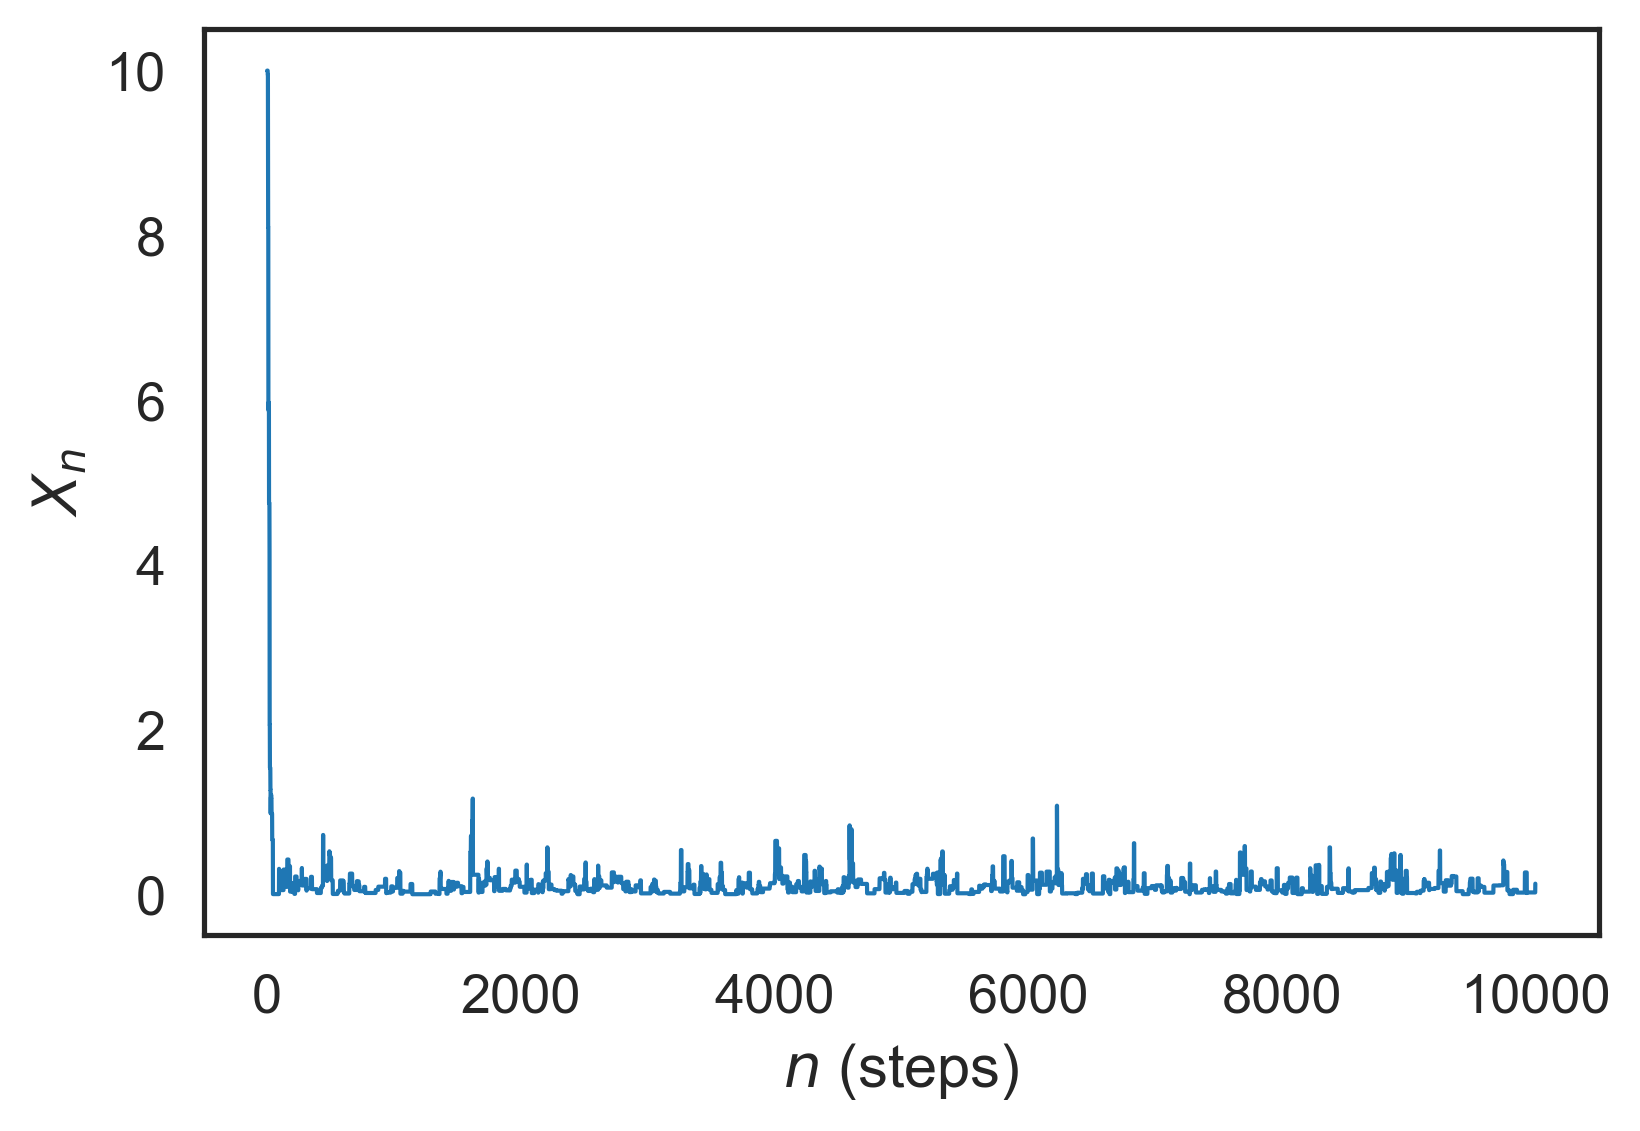

In [6]:
fig, ax = plt.subplots()
ax.plot(range(n + 1), X, lw=1)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$X_n$')

By construction, samples from this chain are supposed to be samples from the right propability distribution.
There are, however, two issues:

+ Ergodicity, guarantees samples only for large $n>n_b$.
At the beginning the chain exhibits transient behavior.
What we need to do is *burn* these initial samples, i.e., we throw them away.
The only reason to see the transient regime is to study the chain path in the figure above.

+ Consecutive samples are highly correleated (as the chain state does not even change if a move is rejected).
Ideally, we want as independent samples as possible.
To achieve this, we need to throw samples in between.
This is called *thinning* the process.
To figure out how to thin the process, you need to look at the *autocorrelation* of the process.
Since, we have a stationary process the autocorrelation is expressed as a function of the time lag $k$ between two steps $n$ and $n+k$:
$$
R(k) = \frac{\mathbb{E}\left[(X_n - \mu)(X_{n+k}-\mu)\right]}{\sigma^2}.
$$
Ideally, you want to think every $k*$ so that:
$$
R(k^*) \approx 0.
$$
That is, you would pick $X_{n_b + k^*}, X_{n_b + 2k*},\dots$.
These samples will look independent.

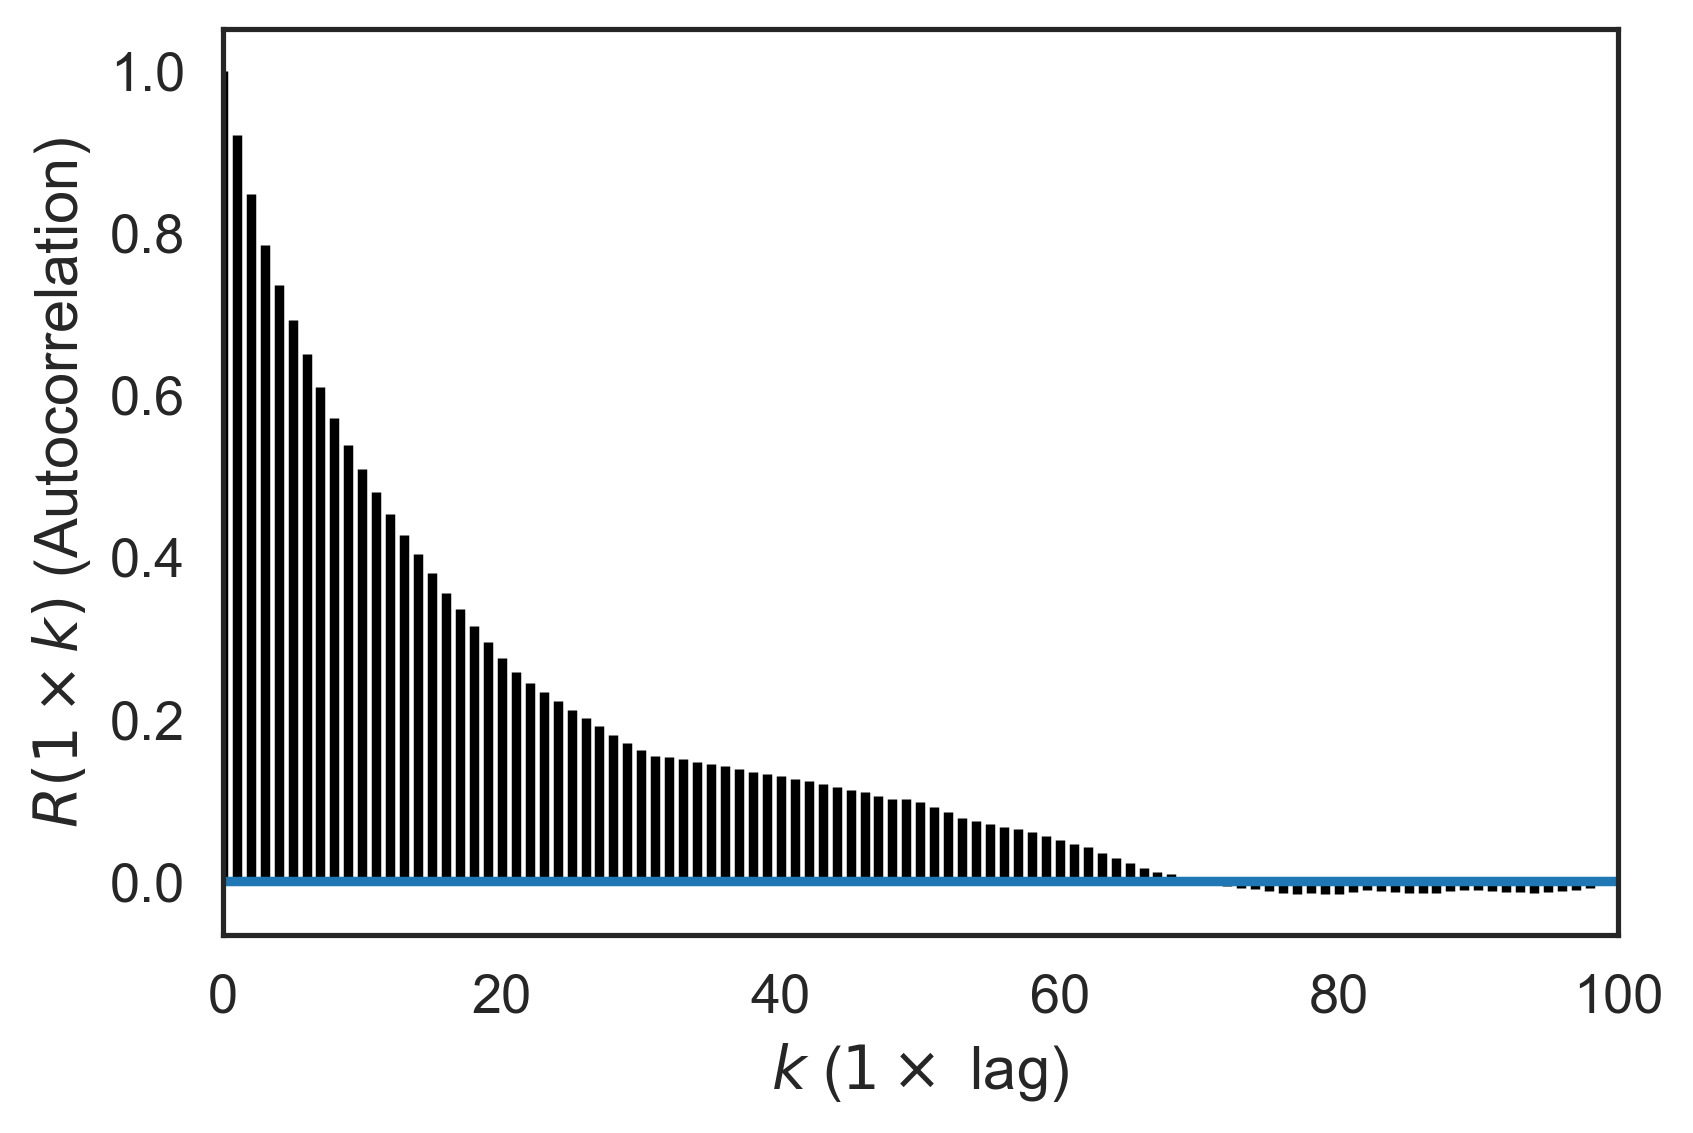

In [7]:
# How many samples do you want to burn?
burn = 200
# How many samples do you want to throw in between?
thin = 1 # Keep one every ten samples (k*)
# Here are the remaining samples:
X_rest = X[burn::thin]
fig, ax = plt.subplots()
ax.acorr(X_rest[:, 0], detrend=plt.mlab.detrend_mean, maxlags=100)
ax.set_xlim(0, 100)
ax.set_ylabel(r'$R(%d \times k)$ (Autocorrelation)' % thin)
ax.set_xlabel(r'$k$ ($%d \times$ lag)' % thin);

If you have chosen ``burn`` and ``thin`` the right way (see questions), you should see samples that look almost independent.
Let's test this:

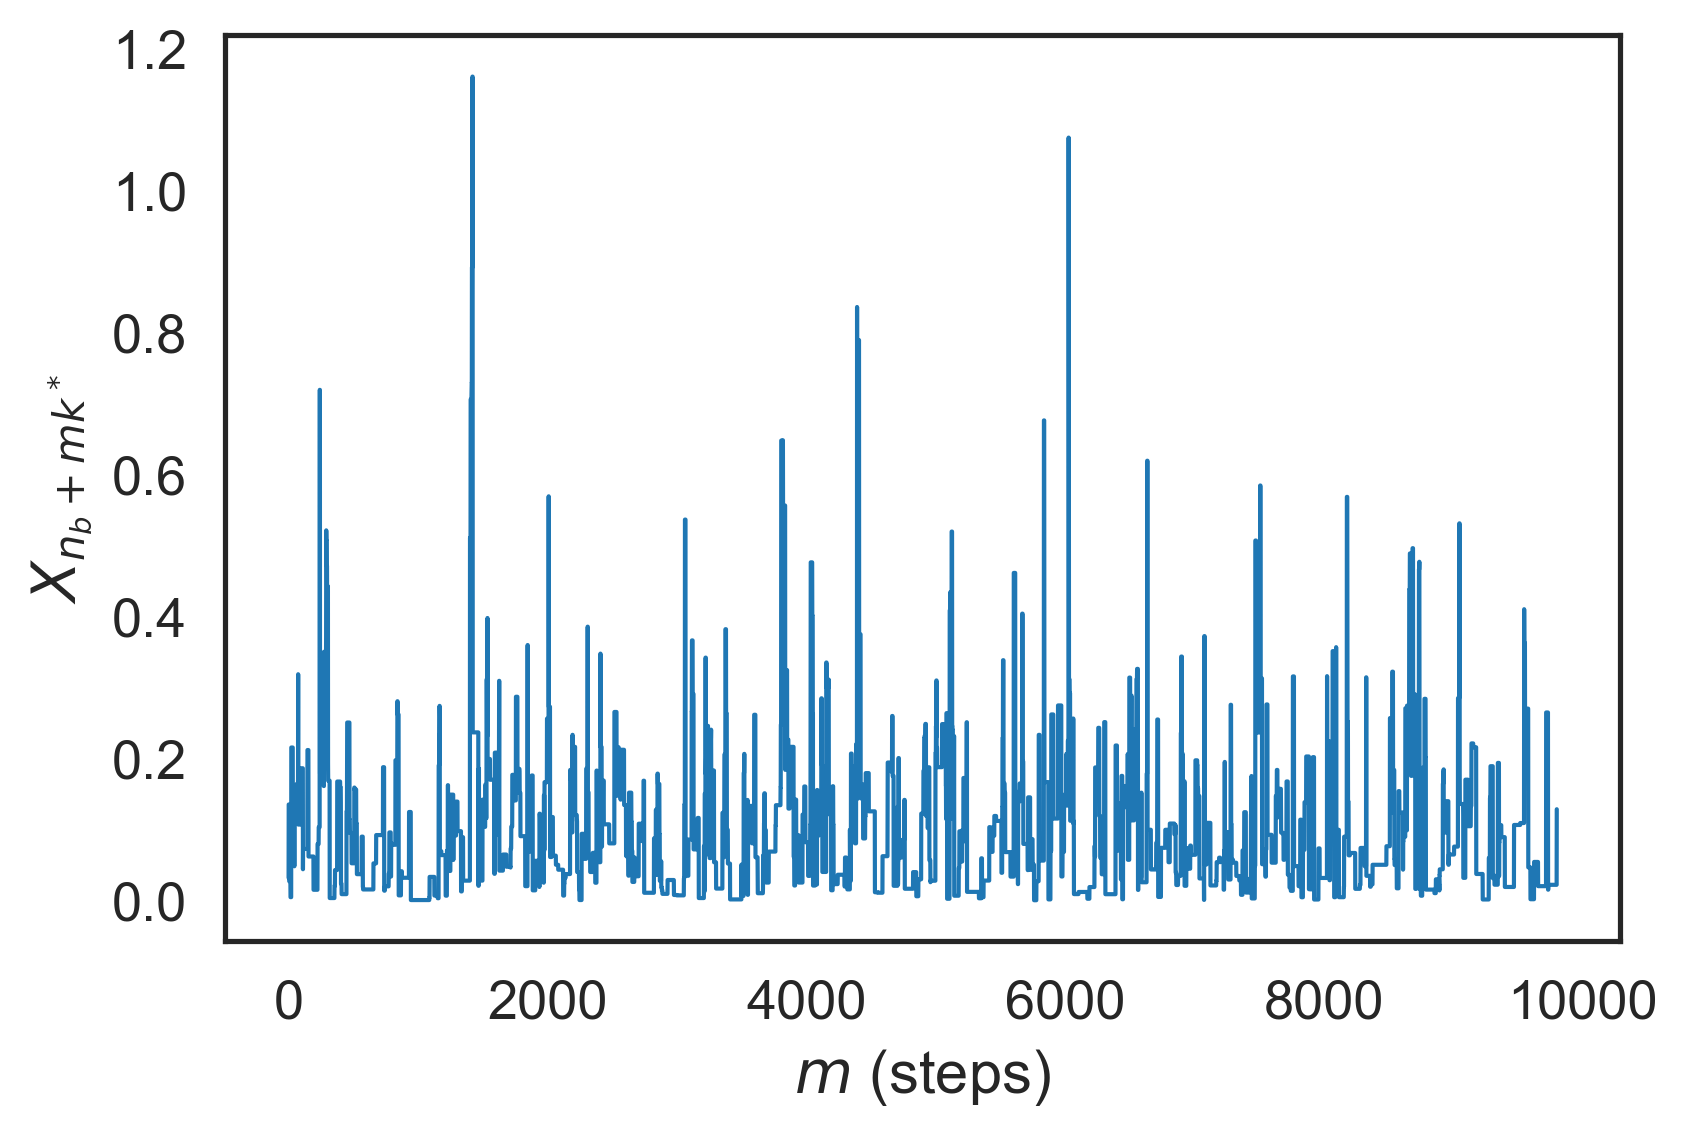

In [8]:
fig, ax = plt.subplots()
ax.plot(X_rest, lw=1.)
ax.set_xlabel('$m$ (steps)')
ax.set_ylabel('$X_{n_b+m k^*}$');

Let's estimate the mean and the variance by sampling average and compare them to the true values.
**Note:** It is also possible to get error bars because the CLT holds (if certain regularity condtions hold), but we do not do it here.

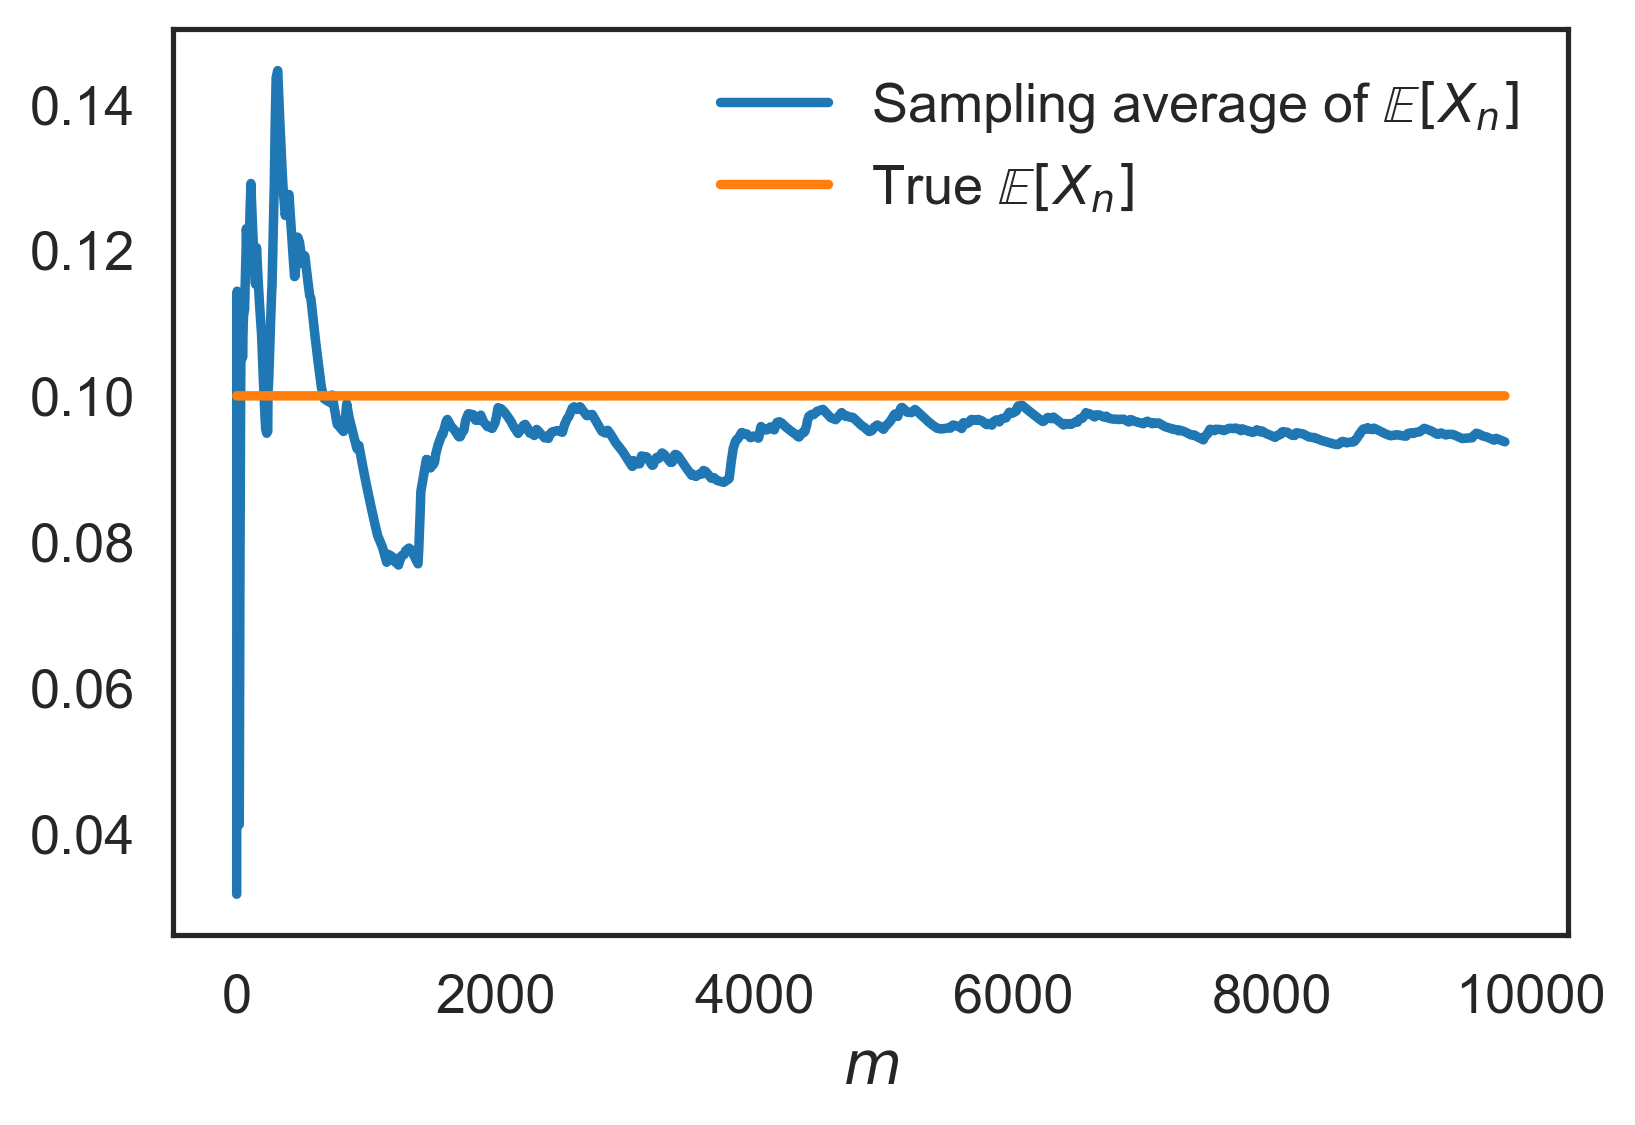

In [9]:
fig, ax = plt.subplots()
idx = np.arange(1, X_rest.shape[0] + 1)
X_ave = np.cumsum(X_rest) / idx
ax.plot(idx, X_ave, label='Sampling average of $\mathbb{E}[X_n]$')
ax.plot(idx, 0.10 * np.ones(idx.shape[0]), label='True $\mathbb{E}[X_n]$')
plt.legend(loc='best')
ax.set_xlabel('$m$');

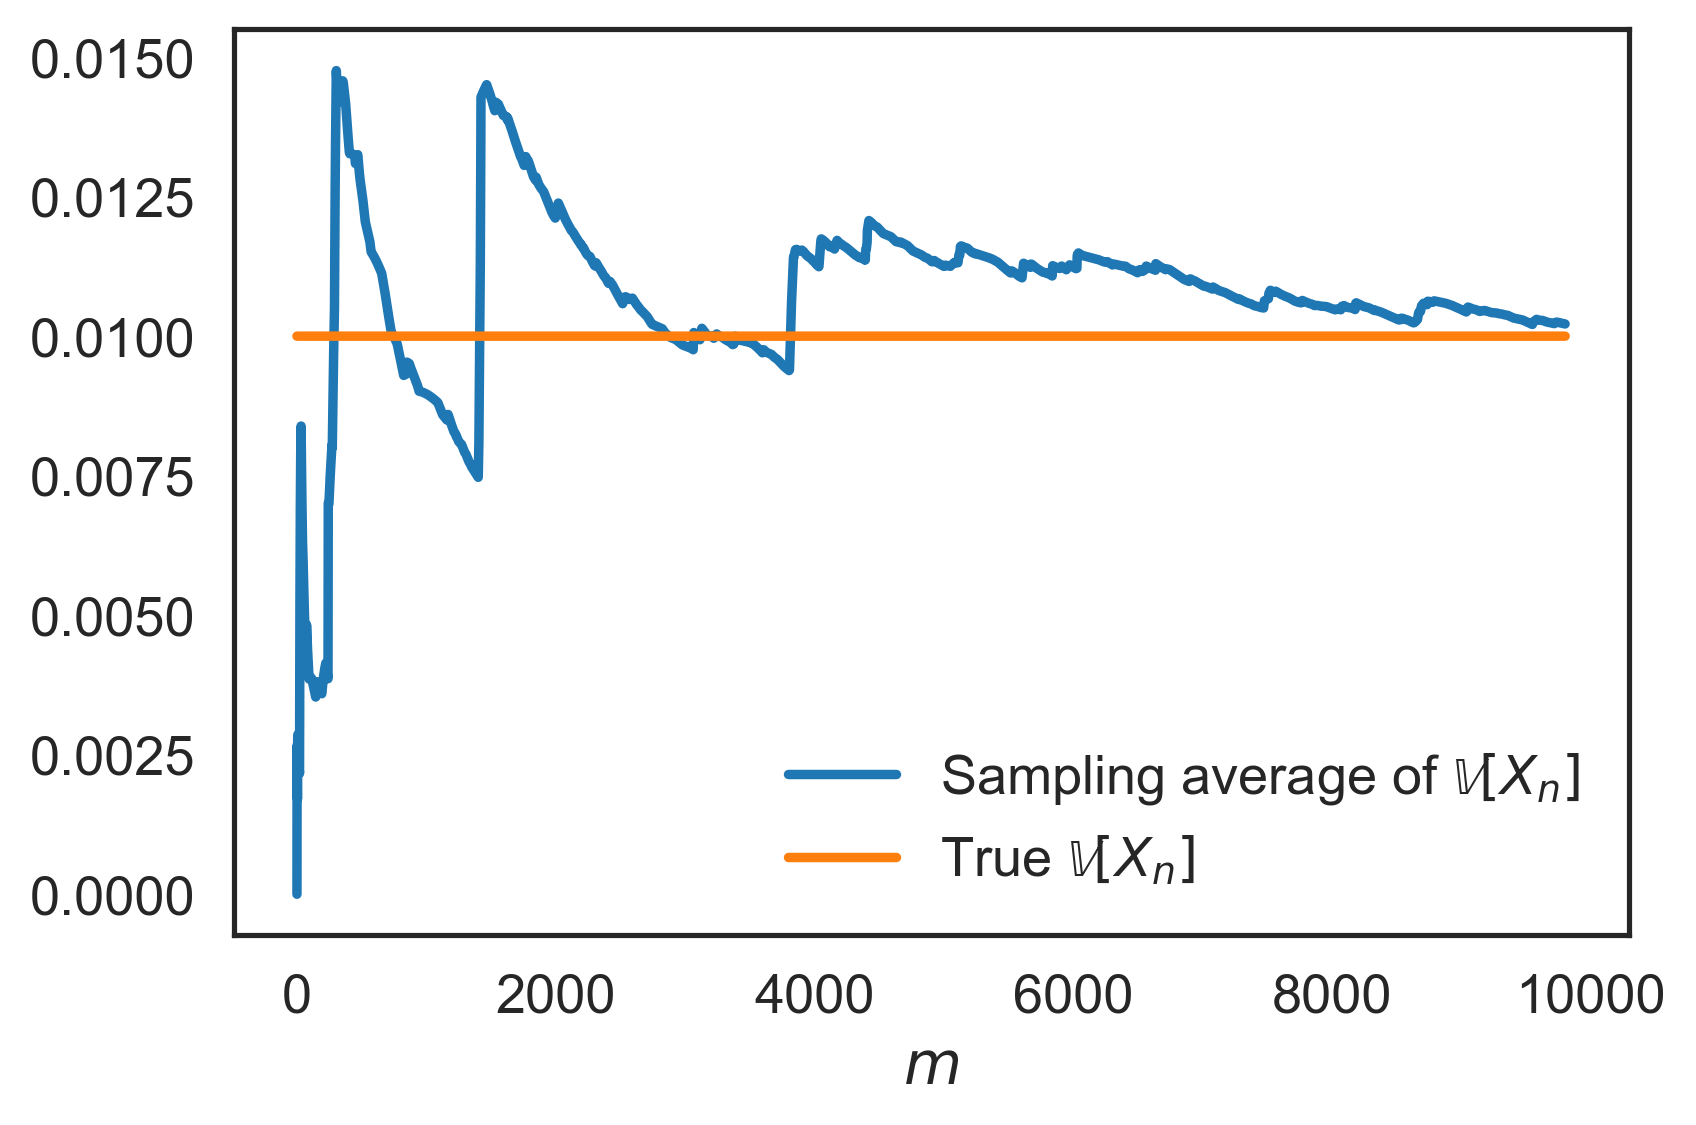

In [10]:
fig, ax = plt.subplots()
X2_ave = np.cumsum(X_rest ** 2) / idx
X_var = X2_ave - X_ave ** 2
ax.plot(idx, X_var, label='Sampling average of $\mathbb{V}[X_n]$')
ax.plot(idx, 0.01 * np.ones(idx.shape[0]), label='True $\mathbb{V}[X_n]$')
plt.legend(loc='best')
ax.set_xlabel('$m$');

Now, let's use these *independent* variables to draw the empirical histrogram and compare it to the true density:

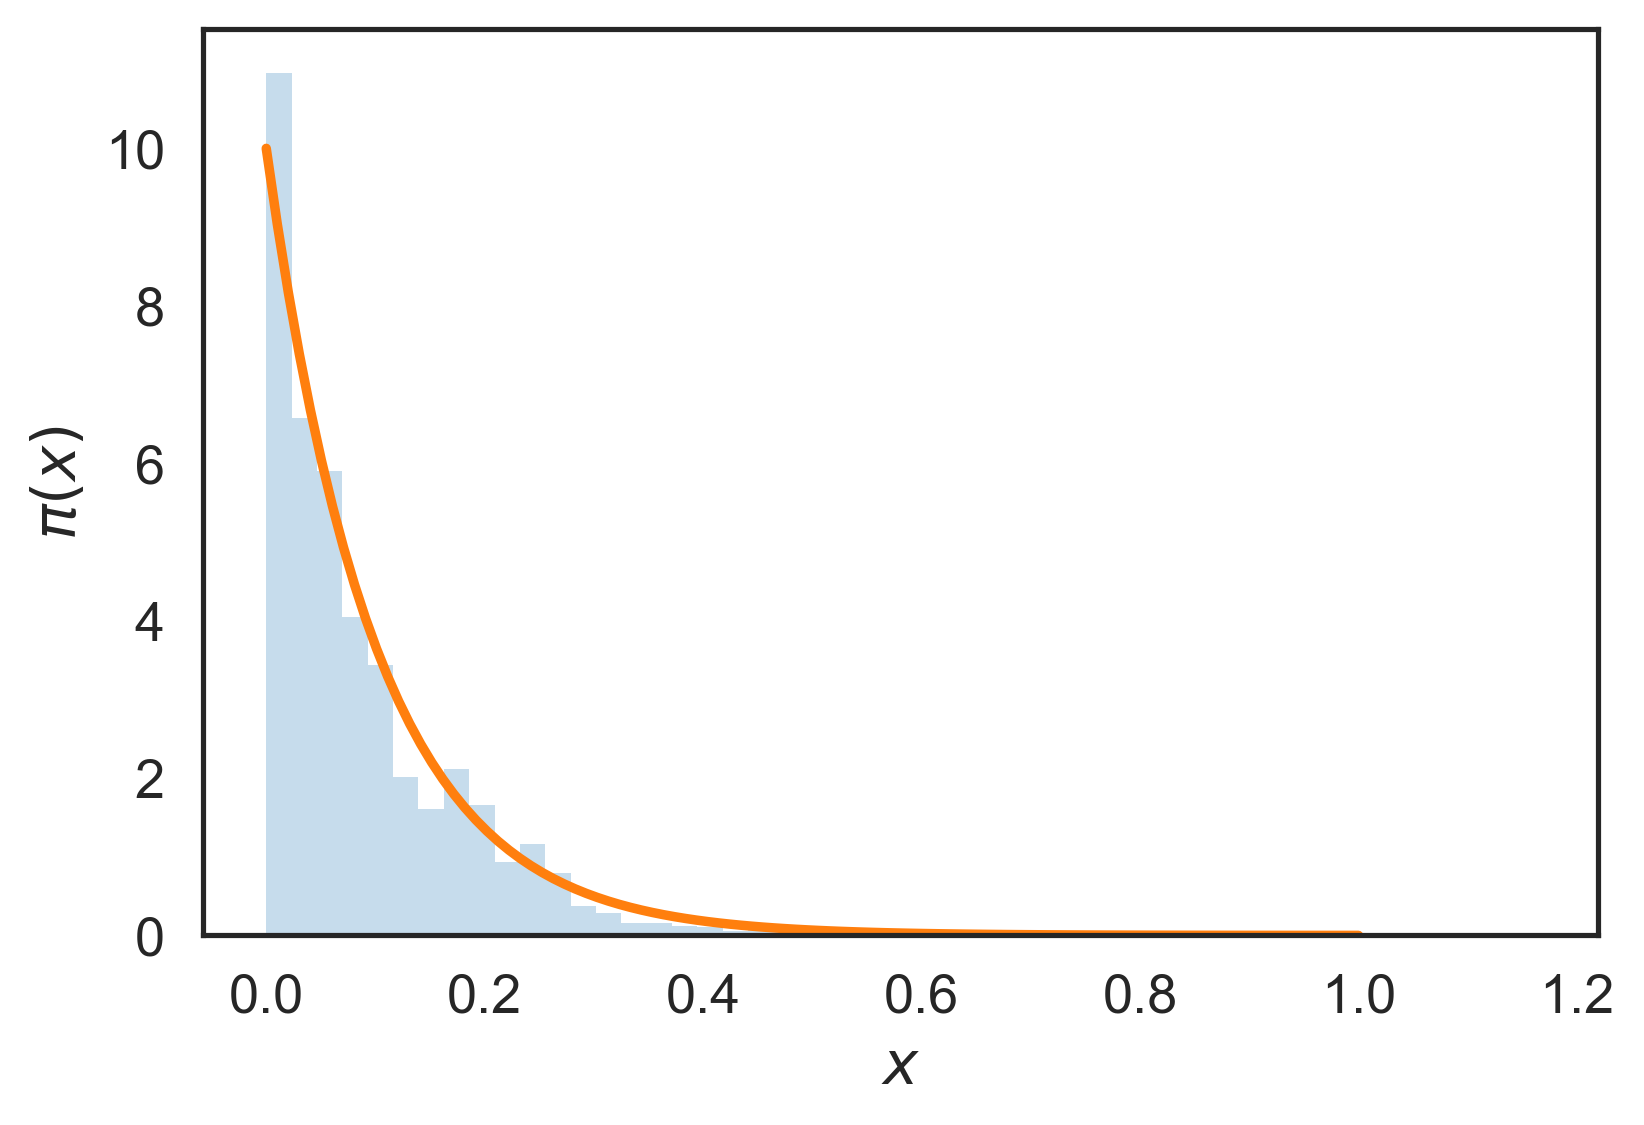

In [11]:
fig, ax = plt.subplots()
ax.hist(X_rest, normed=True, alpha=0.25, bins=50);
xx = np.linspace(0, 1, 100)
ax.plot(xx, 10. * np.exp(-10. * xx))
ax.set_xlabel('$x$')
ax.set_ylabel('$\pi(x)$');

## Questions:

+ Choose ``burn`` so that you ignore the transient regime of the process. How does this affect your averages and you histograms?

+ Choose ``thin`` ($k^*$) so that you make the autocorrelation of almost zero. How does this affect your averages and you histograms?

# Example 4: Sampling from a Beta using Random Walk Metropolis

Let's take $\mathcal{X}=(0,1)$ and:
$$
\pi(x) \propto x^{\alpha-1}(1-x)^{\beta - 1}.
$$
As a proposal distribution, we will use a simple random walk:
$$
T(x_n,x) = \mathcal{N}(x|x_n, \sigma^2),
$$
and we will just pick $\sigma>0$ by hand.
Here we go:

In [12]:
def log_h_beta(x, alpha, beta):
    if x[0] <= 0 or x[0] >= 1:
        return -1e99
    return (alpha - 1.) * np.log(x[0]) + (beta - 1.) * np.log(1. - x[0])

# Initialiazation:
x0 = np.array([.5])
# Parameters of the proposal:
sigma = .1
# Number of steps
n = 1000000
# For which alpha and beta do you want to run it?
alpha = .1
beta = .1

# Start sampling
X, acceptance_rate = rwmetropolis(x0, log_h_beta, n, sigma, args=(alpha, beta))

print 'Acceptance rate: %1.2f' % acceptance_rate

Acceptance rate: 0.33


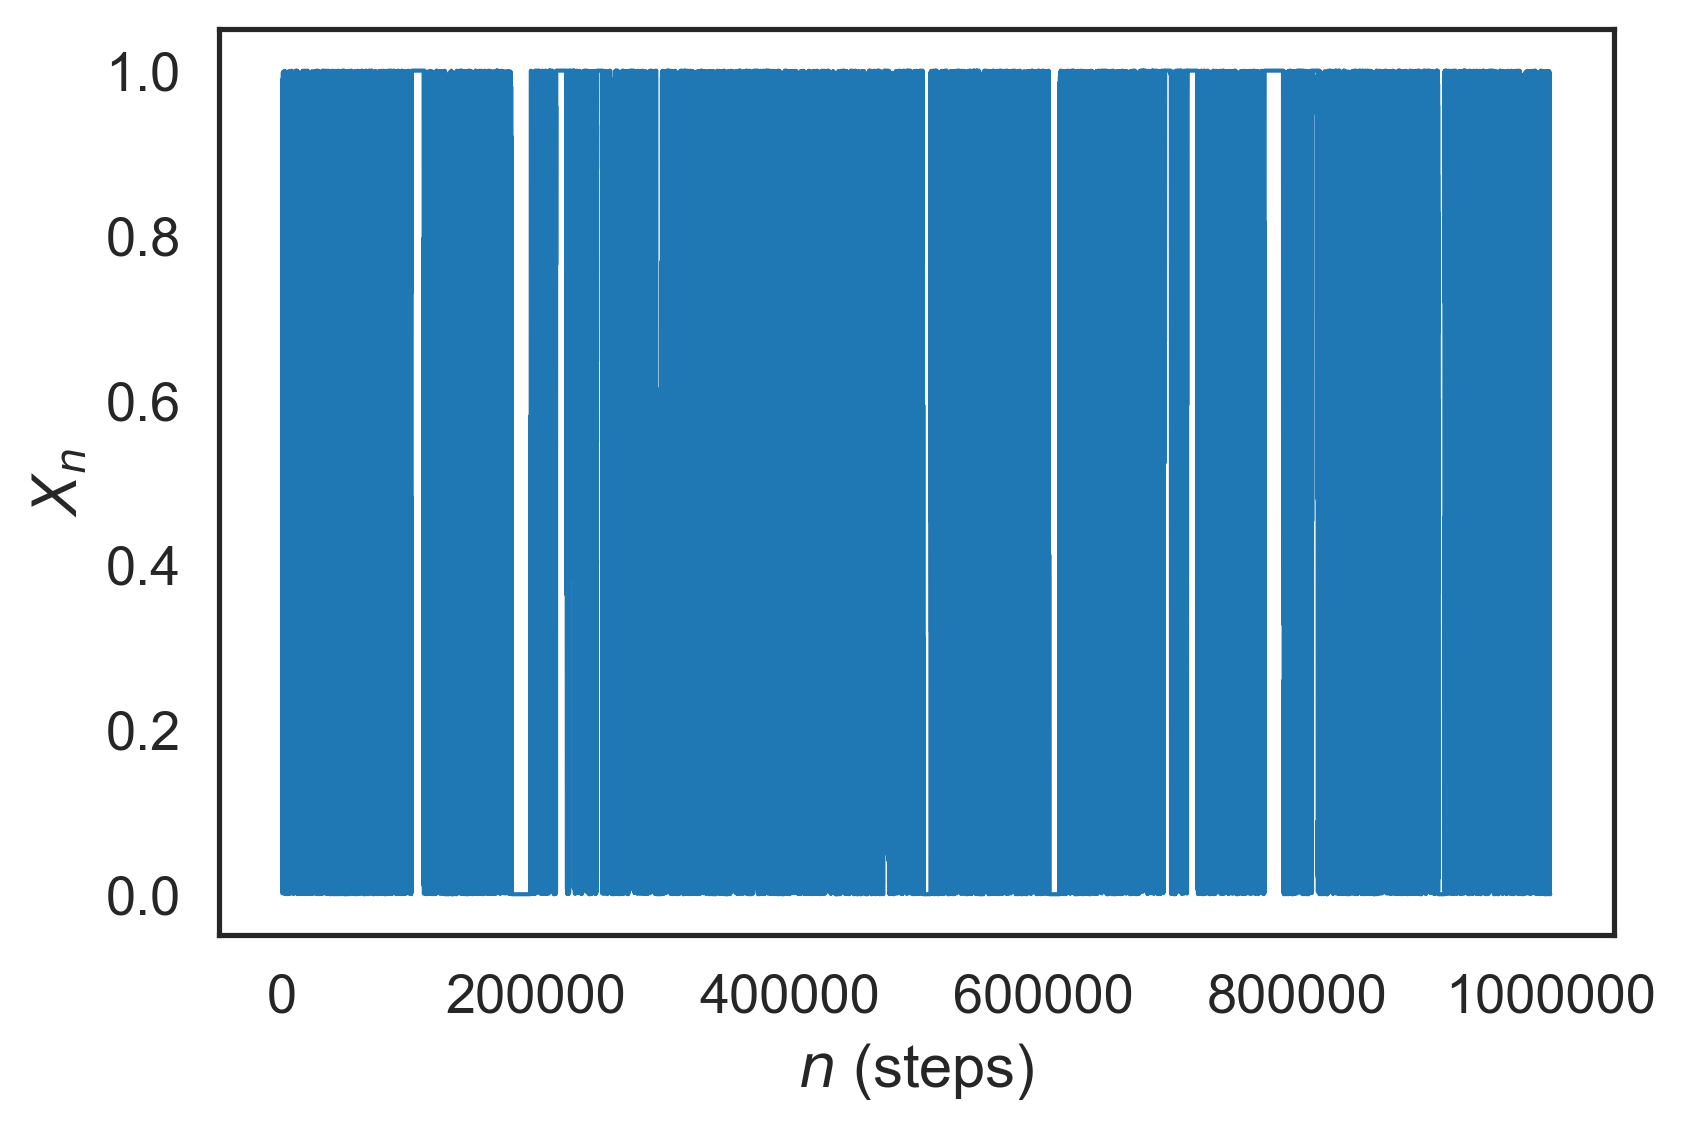

In [13]:
fig, ax = plt.subplots()
ax.plot(range(n + 1), X, lw=1)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$X_n$');

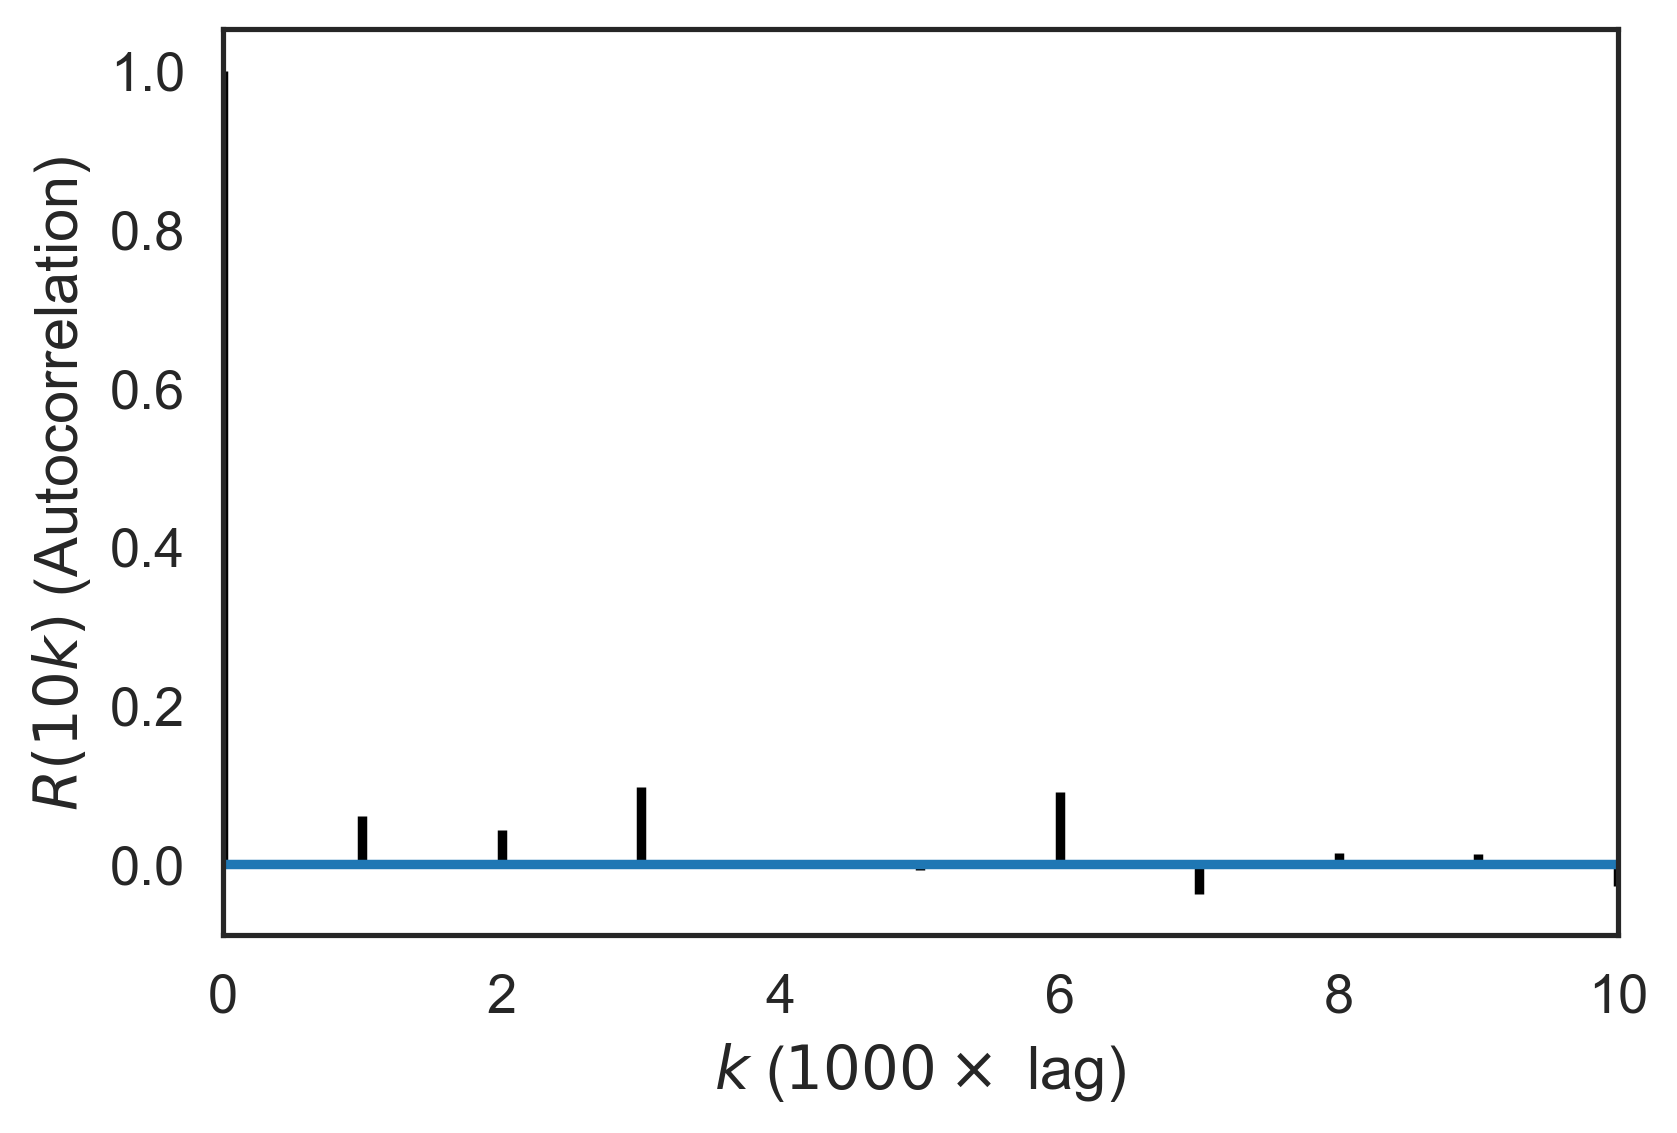

In [14]:
# How many samples do you want to burn?
burn = 10
# How many samples do you want to throw in between?
thin = 1000 # Keep one every ten samples (k*)
# Here are the remaining samples:
X_rest = X[burn::thin]
fig, ax = plt.subplots()
ax.acorr(X_rest[:, 0], detrend=plt.mlab.detrend_mean, maxlags=10)
ax.set_xlim(0, 10)
ax.set_ylabel('$R(10k)$ (Autocorrelation)')
ax.set_xlabel(r'$k$ ($%d \times$ lag)' % thin);

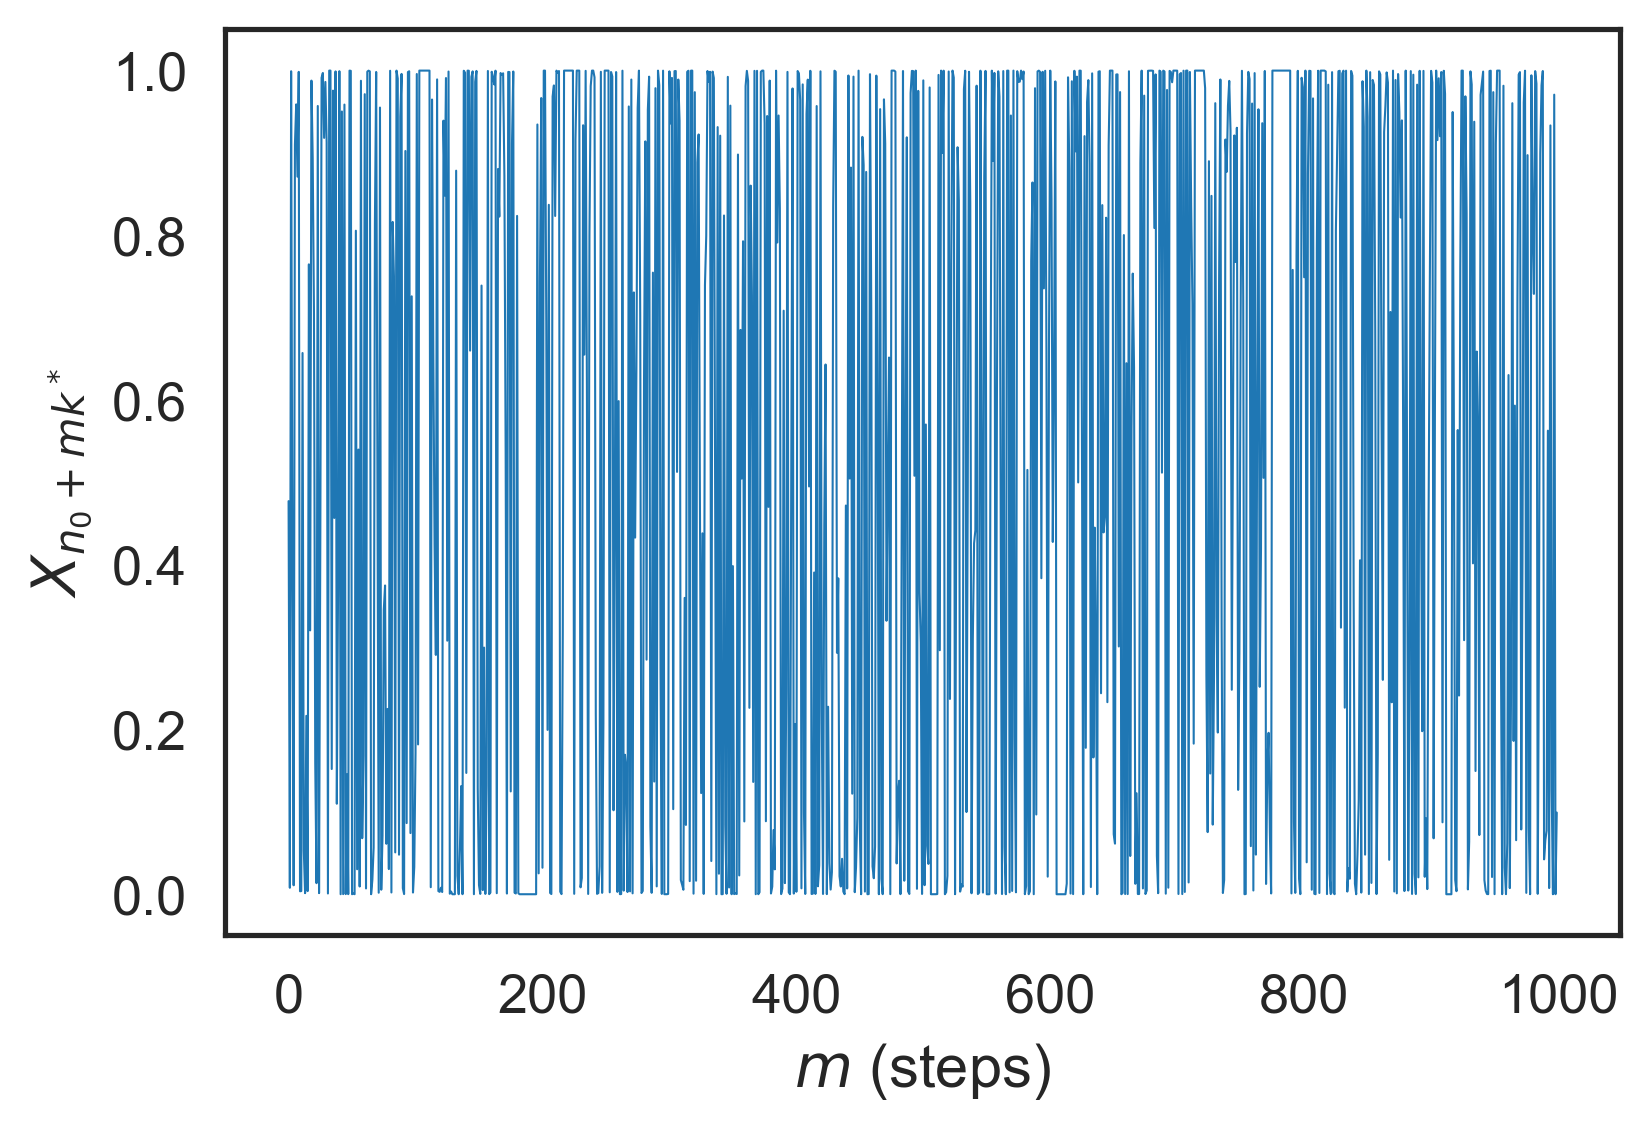

In [15]:
fig, ax = plt.subplots()
ax.plot(X_rest, lw=0.5)
ax.set_xlabel('$m$ (steps)')
ax.set_ylabel('$X_{n_0+m k^*}$');

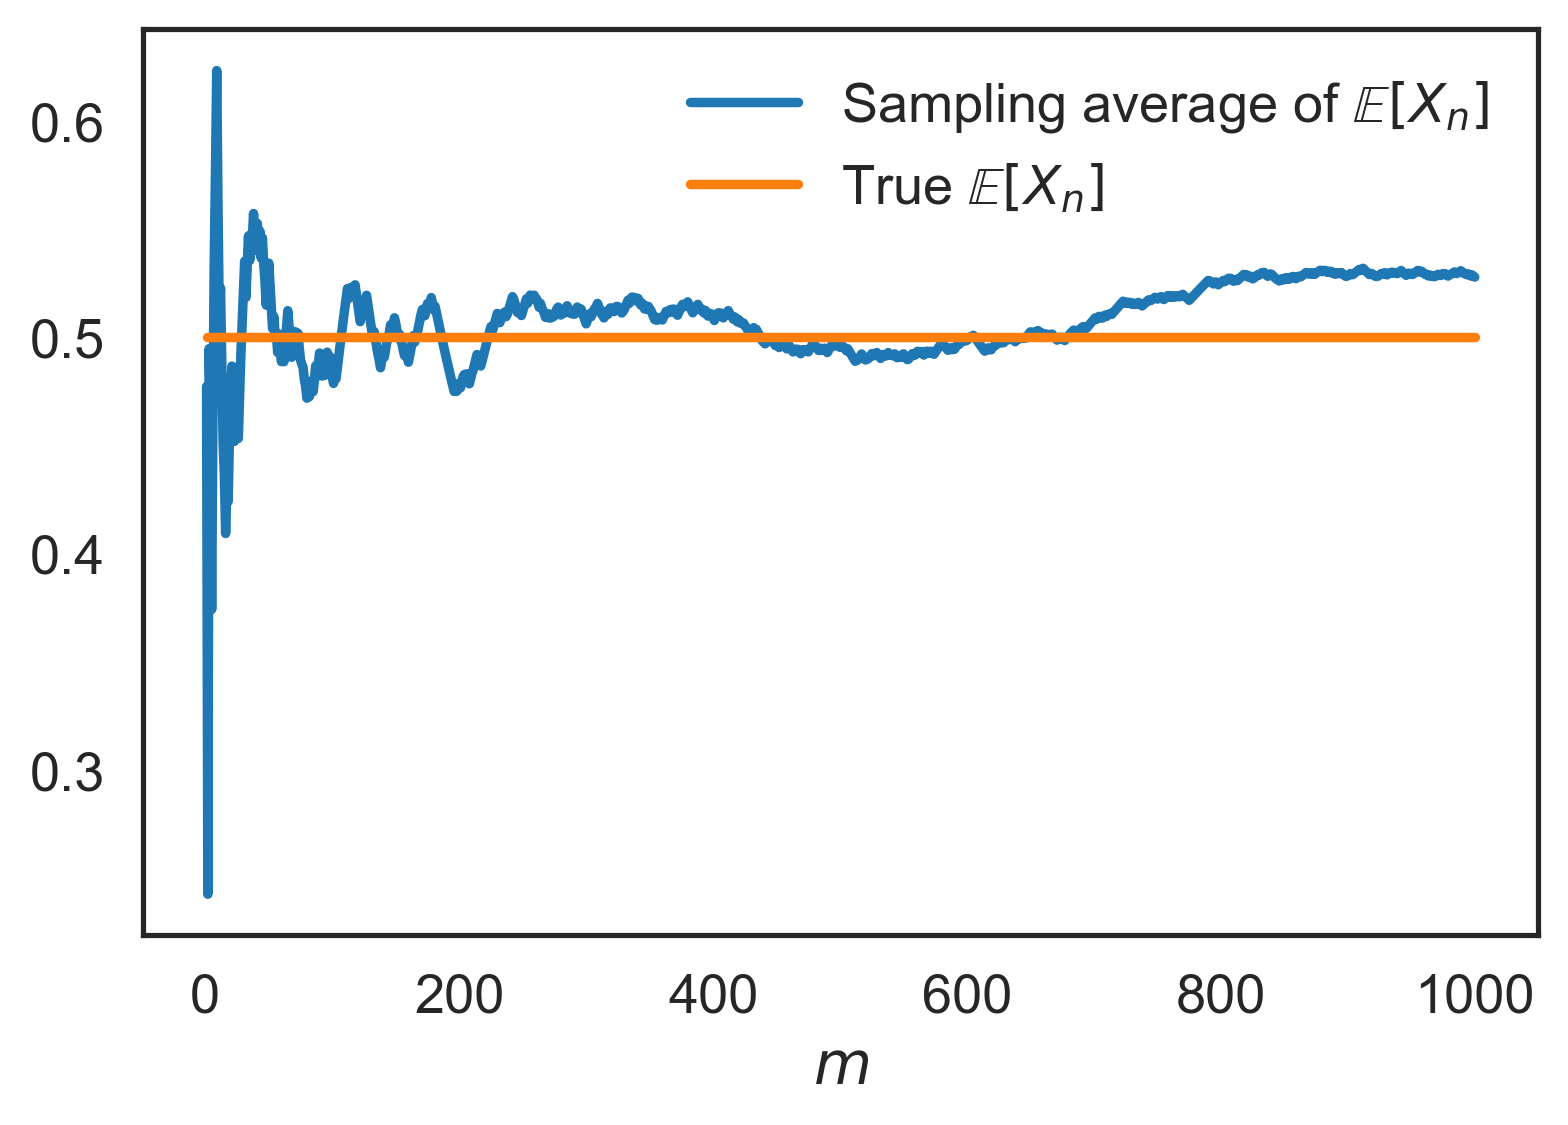

In [16]:
fig, ax = plt.subplots()
idx = np.arange(1, X_rest.shape[0] + 1)
X_ave = np.cumsum(X_rest) / idx
ax.plot(idx, X_ave, label='Sampling average of $\mathbb{E}[X_n]$')
ax.plot(idx, alpha / (alpha + beta) * np.ones(idx.shape[0]), label='True $\mathbb{E}[X_n]$')
plt.legend(loc='best')
ax.set_xlabel('$m$');

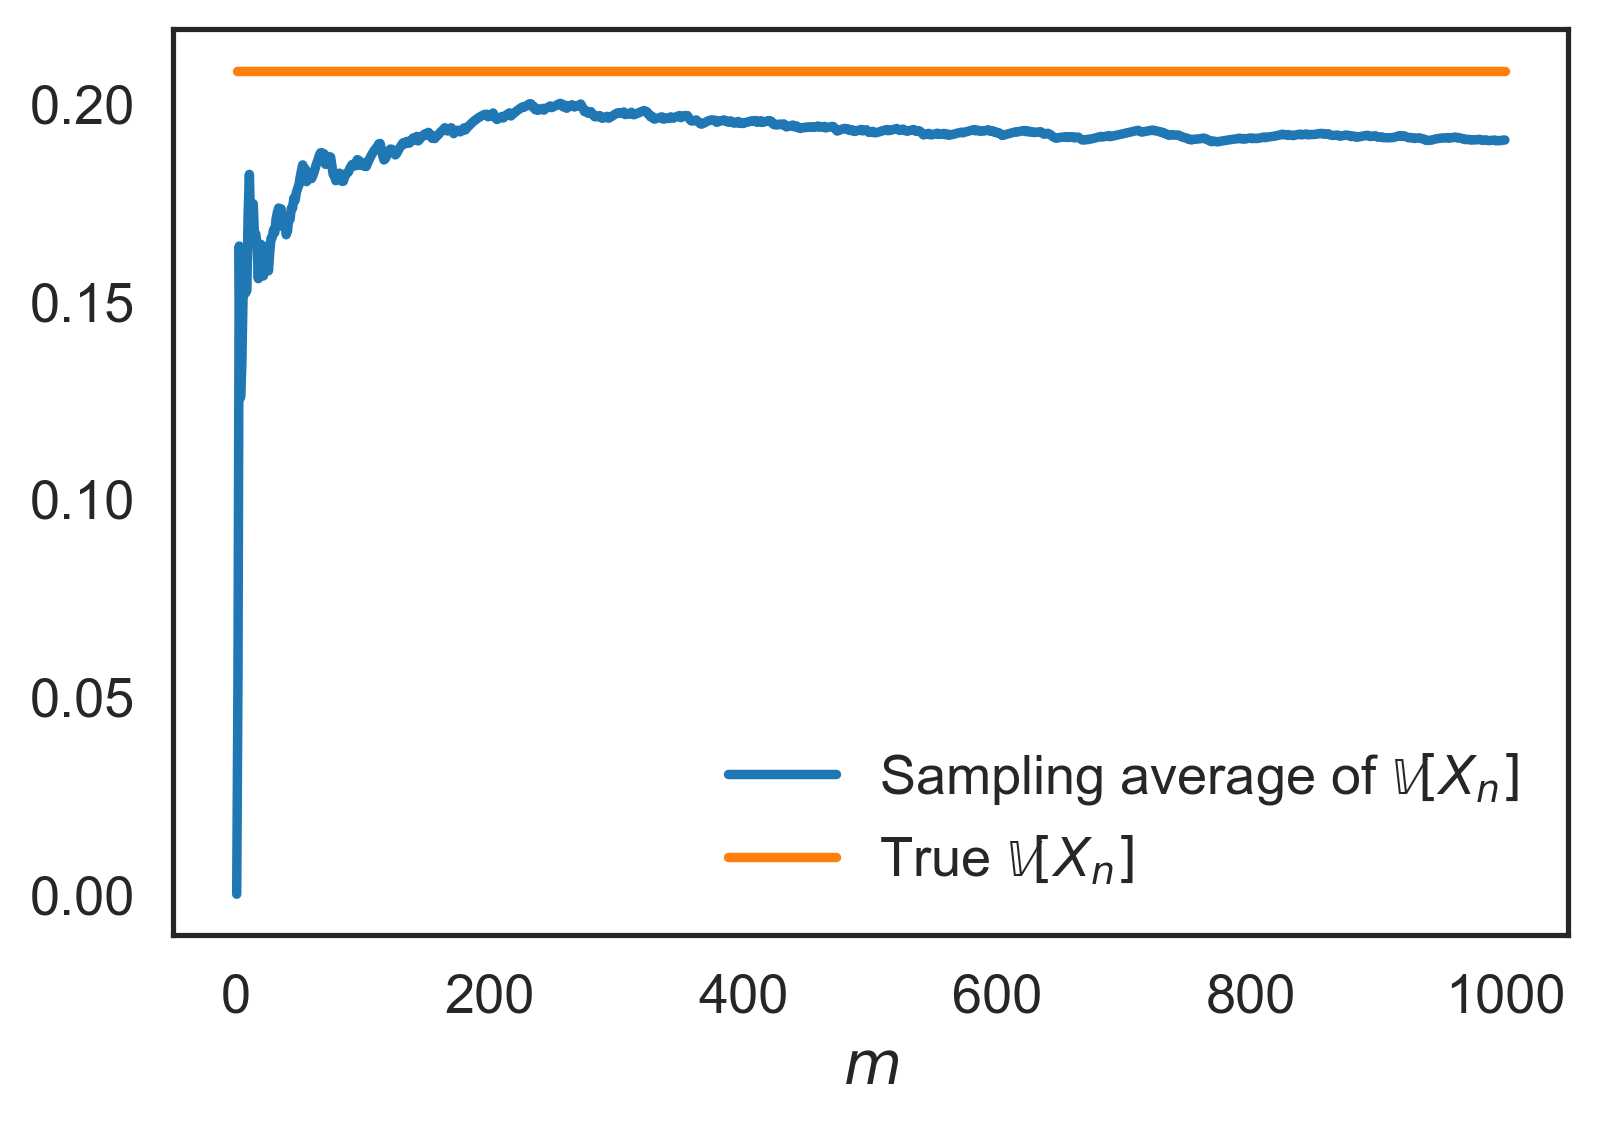

In [17]:
fig, ax = plt.subplots()
X2_ave = np.cumsum(X_rest ** 2) / idx
X_var = X2_ave - X_ave ** 2
ax.plot(idx, X_var, label='Sampling average of $\mathbb{V}[X_n]$')
ax.plot(idx, alpha * beta / ((alpha + beta) ** 2 * (alpha + beta + 1)) * np.ones(idx.shape[0]), label='True $\mathbb{V}[X_n]$')
plt.legend(loc='best')
ax.set_xlabel('$m$');

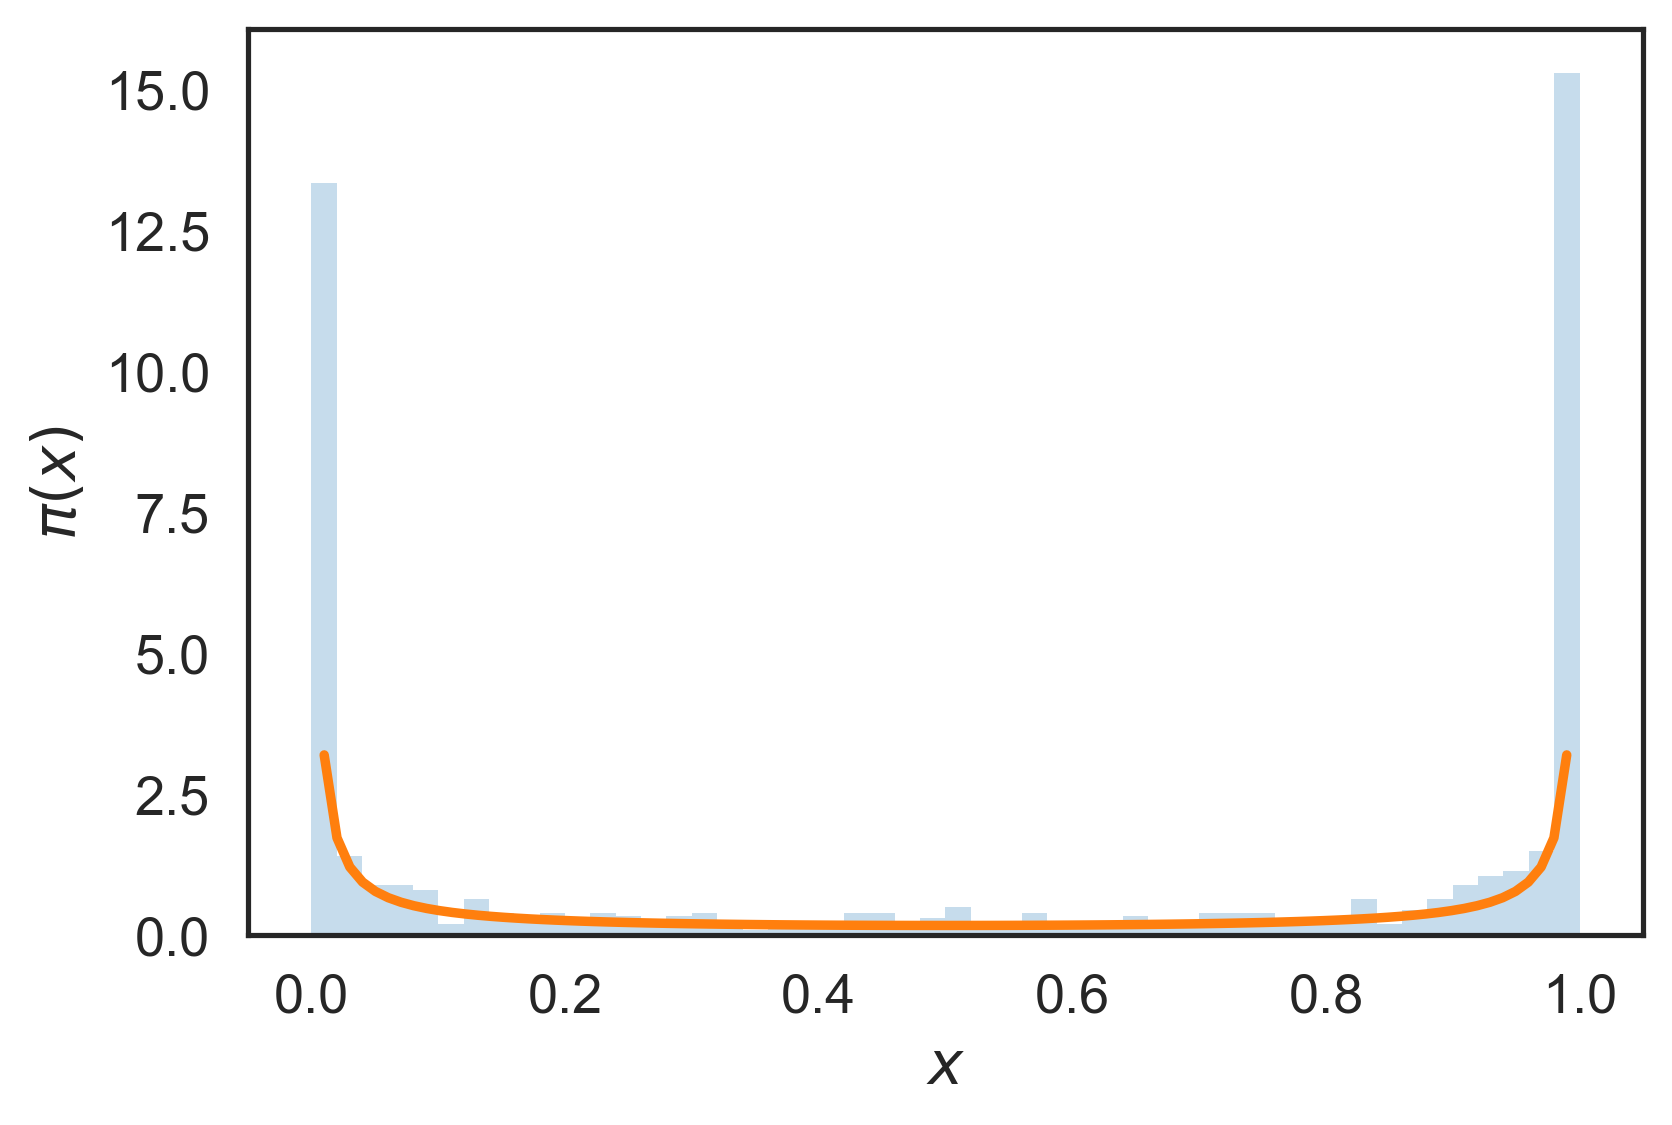

In [18]:
fig, ax = plt.subplots()
ax.hist(X_rest, normed=True, alpha=0.25, bins=50);
xx = np.linspace(0, 1, 100)
ax.plot(xx, st.beta(alpha, beta).pdf(xx))
ax.set_xlabel('$x$')
ax.set_ylabel('$\pi(x)$');

## Questions

+ For $\alpha = 2, \beta=5$ do the following:
    - find the $\sigma$ that gives you an acceptance rate of about $0.25$.
    - find how many samples $n_b$ you need to burn to get over the transient (if any).
    - find how many samples $k^*$ you need to drop in between to drive the autocorrelation down to almost zero.
    
+ Repeat the steps above for $\alpha = 0.5$ and $\beta=0.5$. What do you observe now that you have two modes?

+ Repeat the steps above for $\alpha = 0.1$ and $\beta=0.1$. What do you observe now that your modes are even more pronounced?

# Example 5: Sampling from a Gaussian with Random Walk Metropolis

Let's take $\mathcal{X}=\mathbb{R}^2$ and:
$$
\pi(x) \propto \exp\left\{-\frac{1}{2}\left(x-\mu\right)^T\Lambda(x-\mu)\right\},
$$
where $\mu\in\mathbb{R}^2$ is the mean and $\Lambda = \Sigma^{-1}\in\mathbb{R}^{2\times 2}$ is the precision matrix.
As a proposal distribution, we will use a simple random walk:
$$
T(x_n,x) = \mathcal{N}(x|x_n, \sigma^2 I_2),
$$
and we will just pick $\sigma>0$ by hand.
Here we go:

In [19]:
# The log of the density (up to a normalizing constant) of the distribution from which we want to sample:
def log_h_mvn(x, mu, Lambda):
    tmp = x - mu
    return -0.5 * np.dot(tmp, np.dot(Lambda, tmp))

# The parameters of the disribution from which we wish to sample
mu = np.array([5., 2.])
Sigma = np.array([[1., .4],
                  [.3, 0.2]]) # This has to be positive definite - otherwise you will get garbage!
Lambda = np.linalg.inv(Sigma)

# Initialiazation:
x0 = np.array([-5., 5.])
# Parameters of the proposal:
sigma = 0.2
# Number of steps:
n = 10000

# Start sampling
X, acceptance_rate = rwmetropolis(x0, log_h_mvn, n, sigma, args=(mu, Lambda))

print 'Acceptance rate: %1.2f' % acceptance_rate

Acceptance rate: 0.74


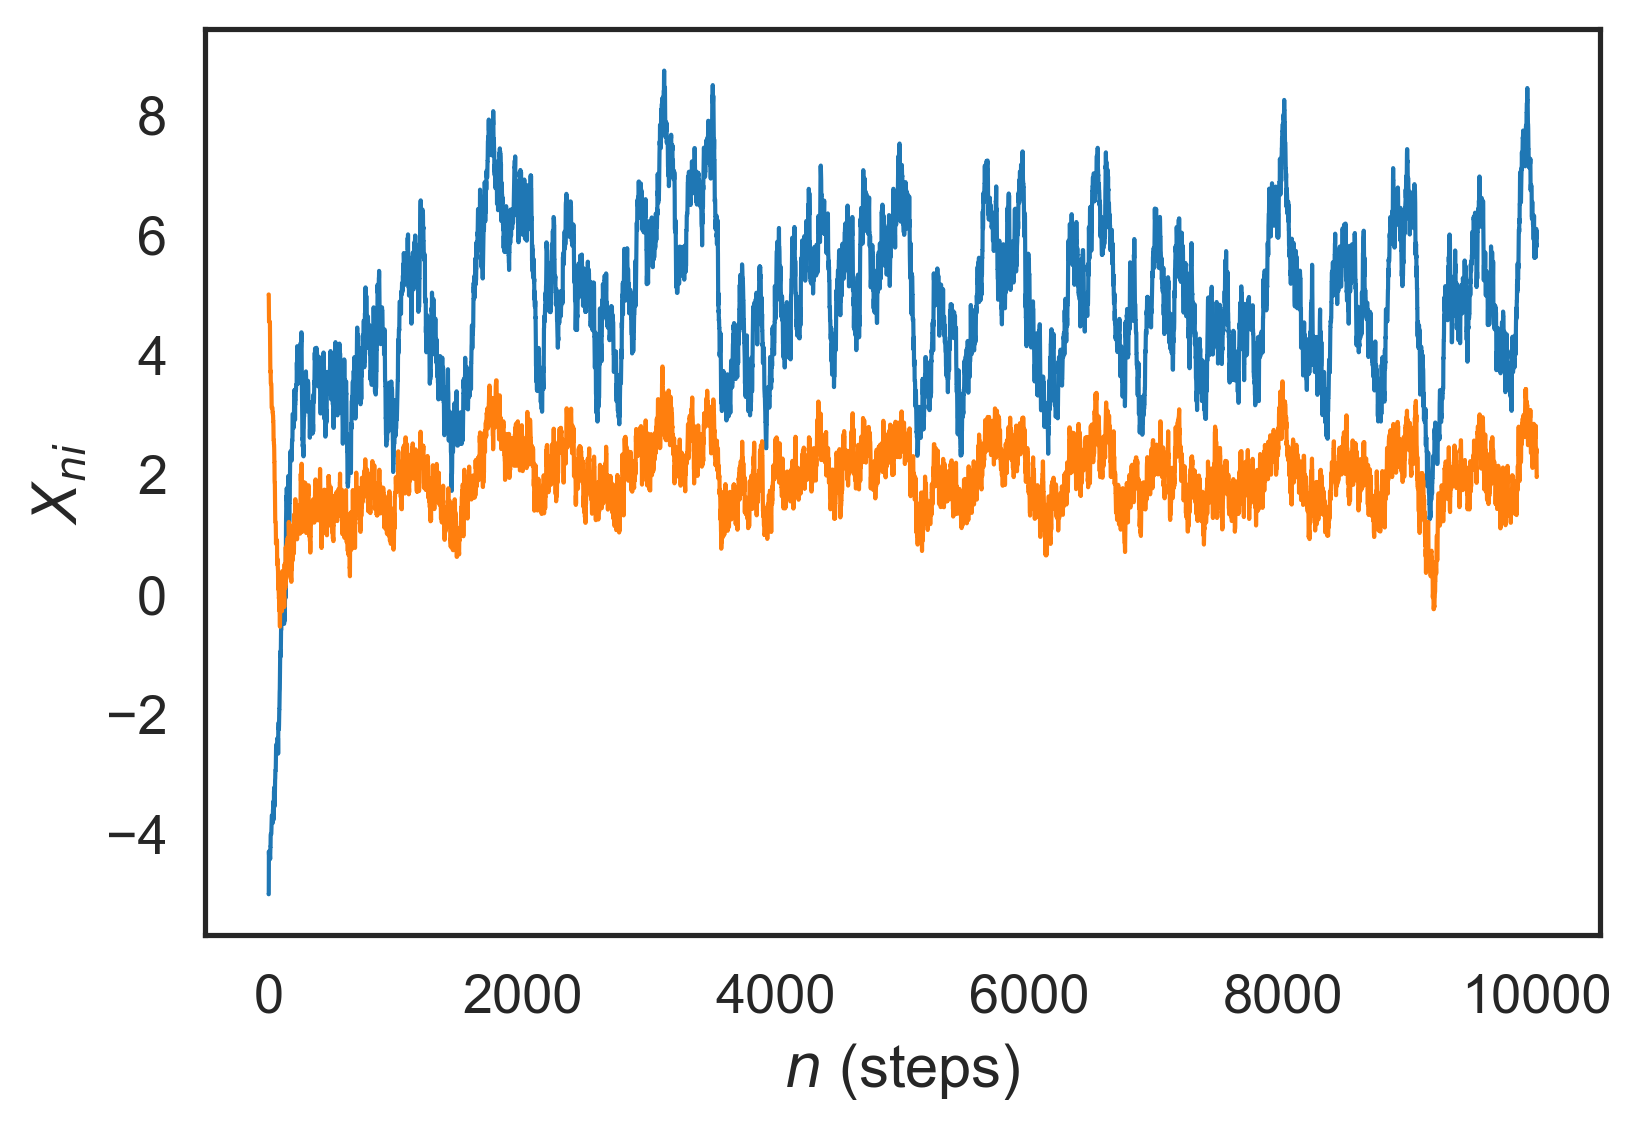

In [20]:
fig, ax = plt.subplots()
ax.plot(range(n + 1), X, lw=1)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$X_{ni}$');

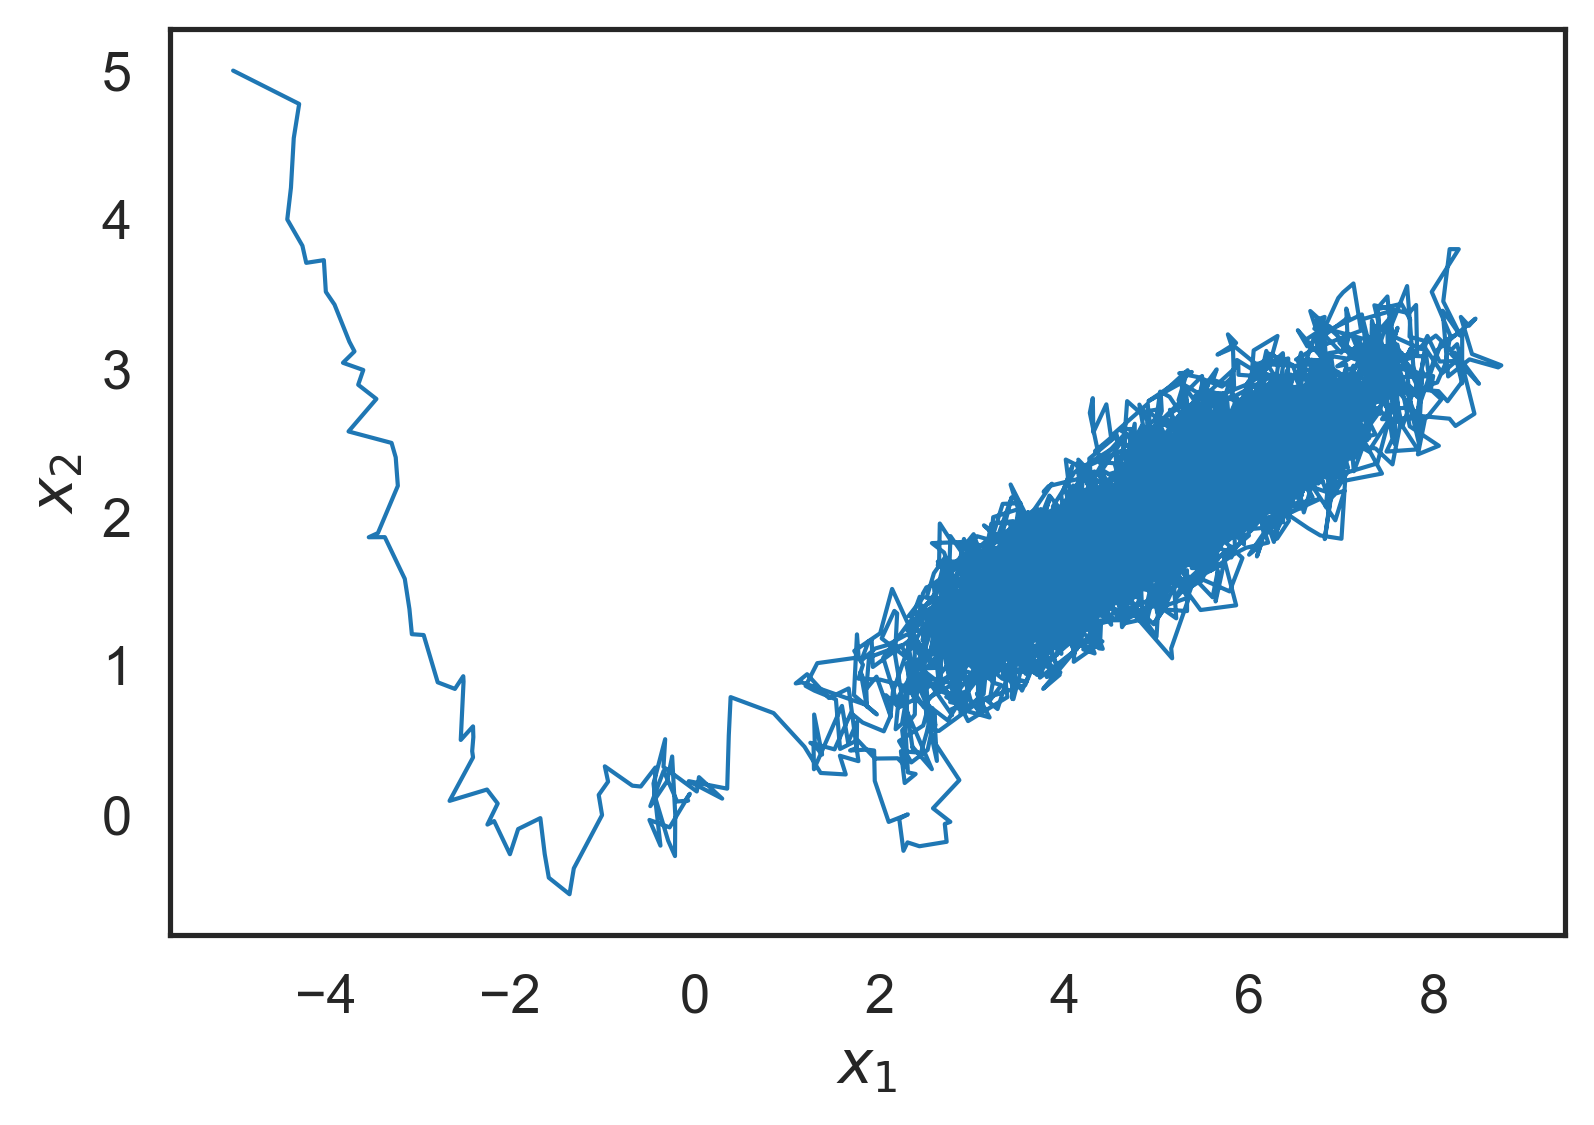

In [21]:
fig, ax = plt.subplots()
ax.plot(X[:, 0], X[:, 1], lw=1)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

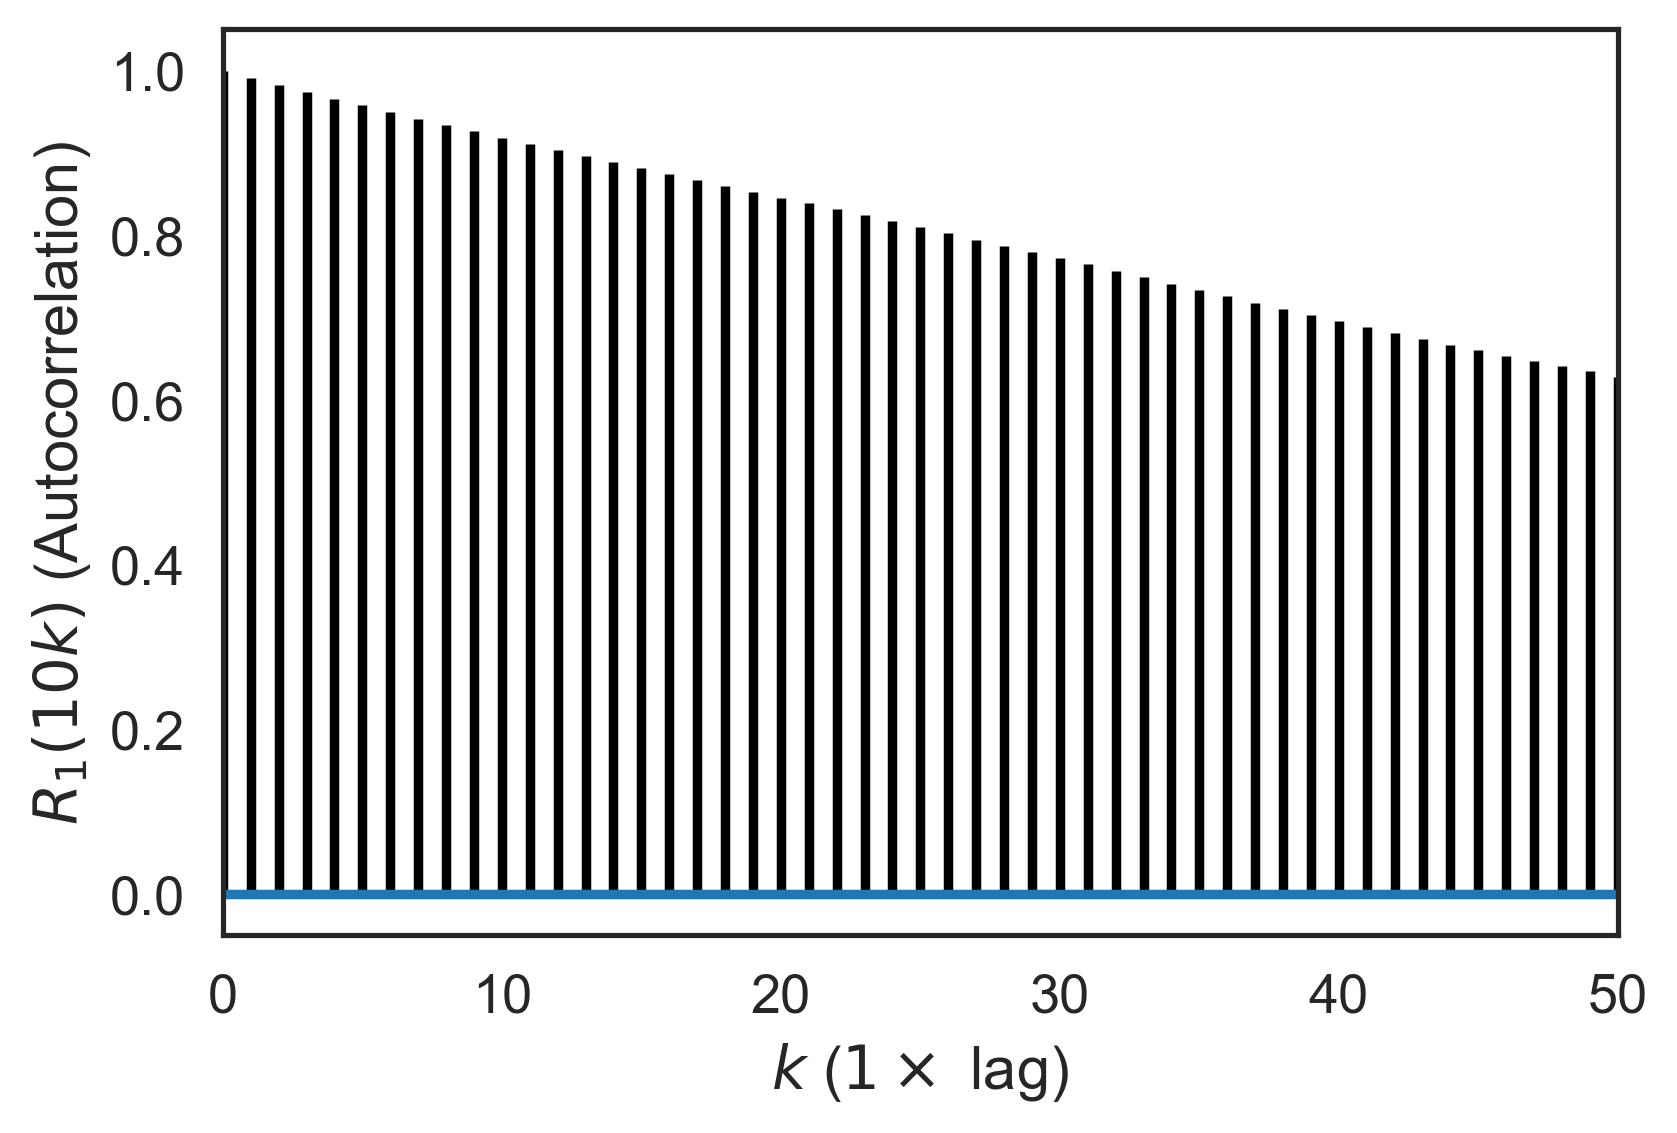

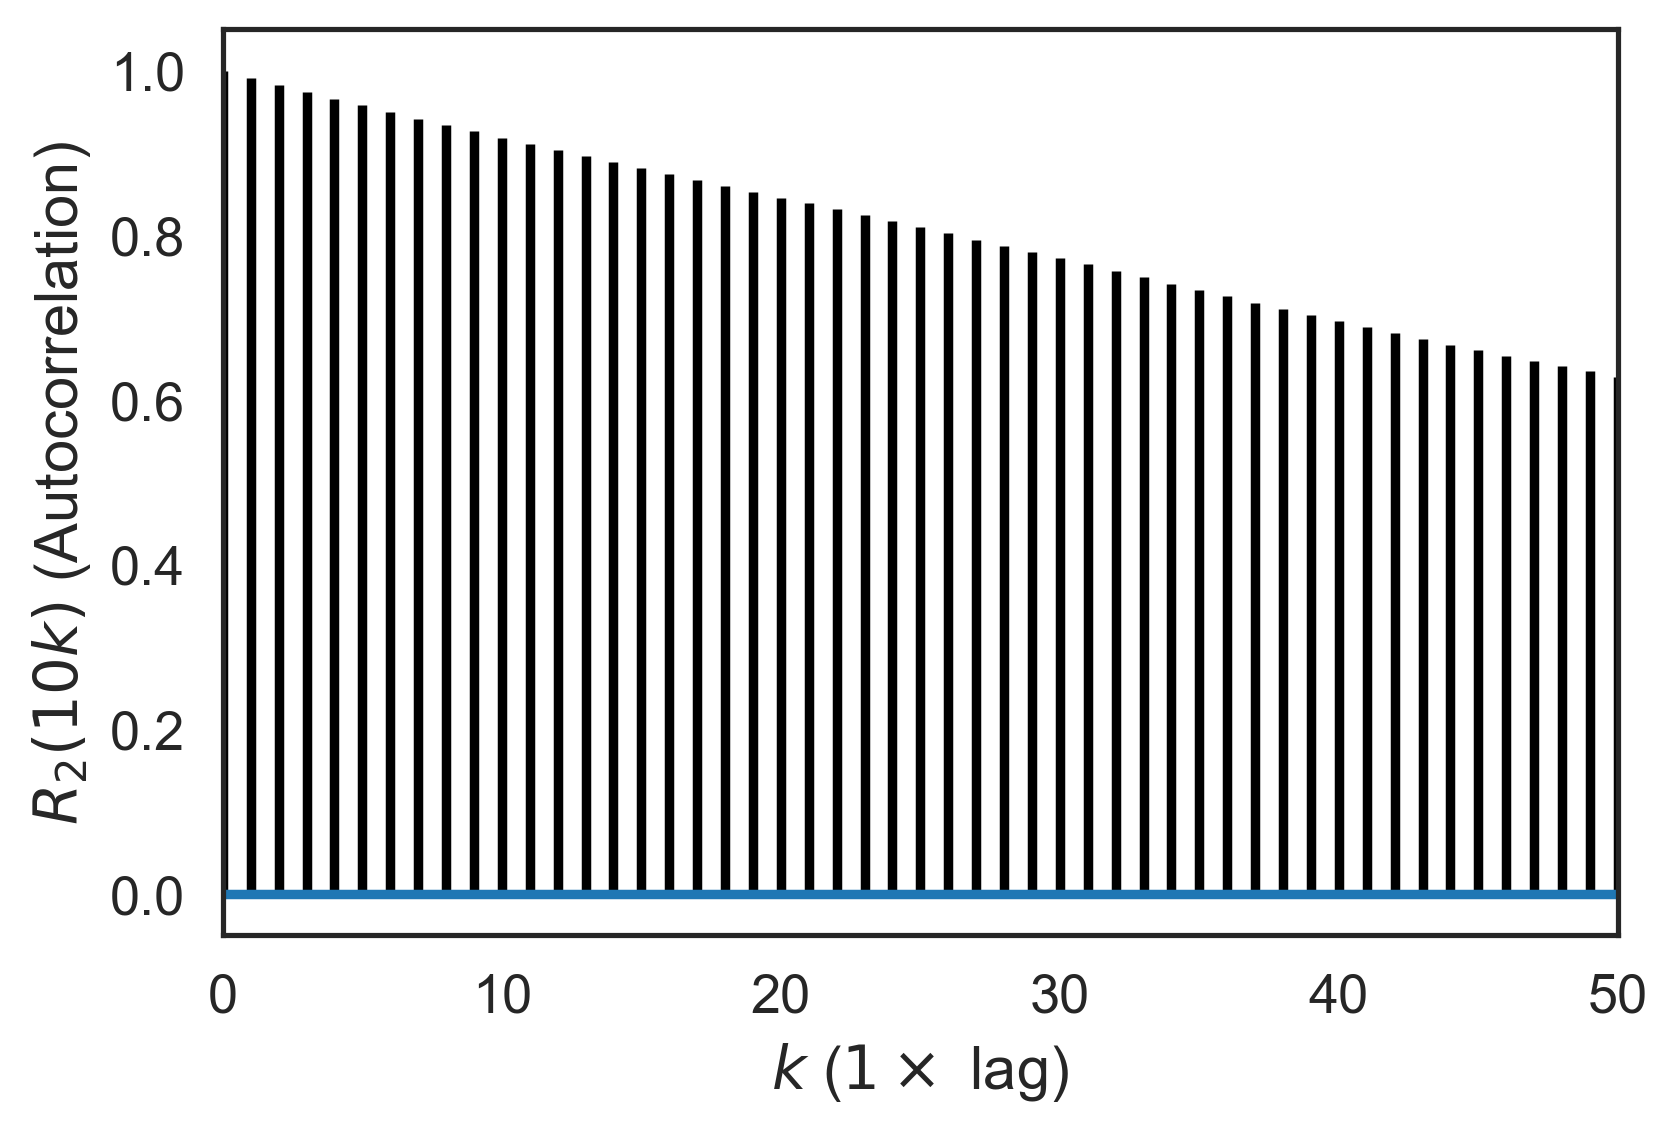

In [22]:
# How many samples do you want to burn?
burn = 100
# How many samples do you want to throw in between?
thin = 1 # Keep one every ten samples (k*)
# Here are the remaining samples:
X_rest = X[burn::thin]
for i in range(X_rest.shape[1]):
    fig, ax = plt.subplots()
    ax.acorr(X_rest[:, 0], detrend=plt.mlab.detrend_mean, maxlags=50)
    ax.set_xlim(0, 50)
    ax.set_ylabel('$R_{%d}(10k)$ (Autocorrelation)' % (i + 1))
    ax.set_xlabel(r'$k$ ($%d \times$ lag)' % thin);

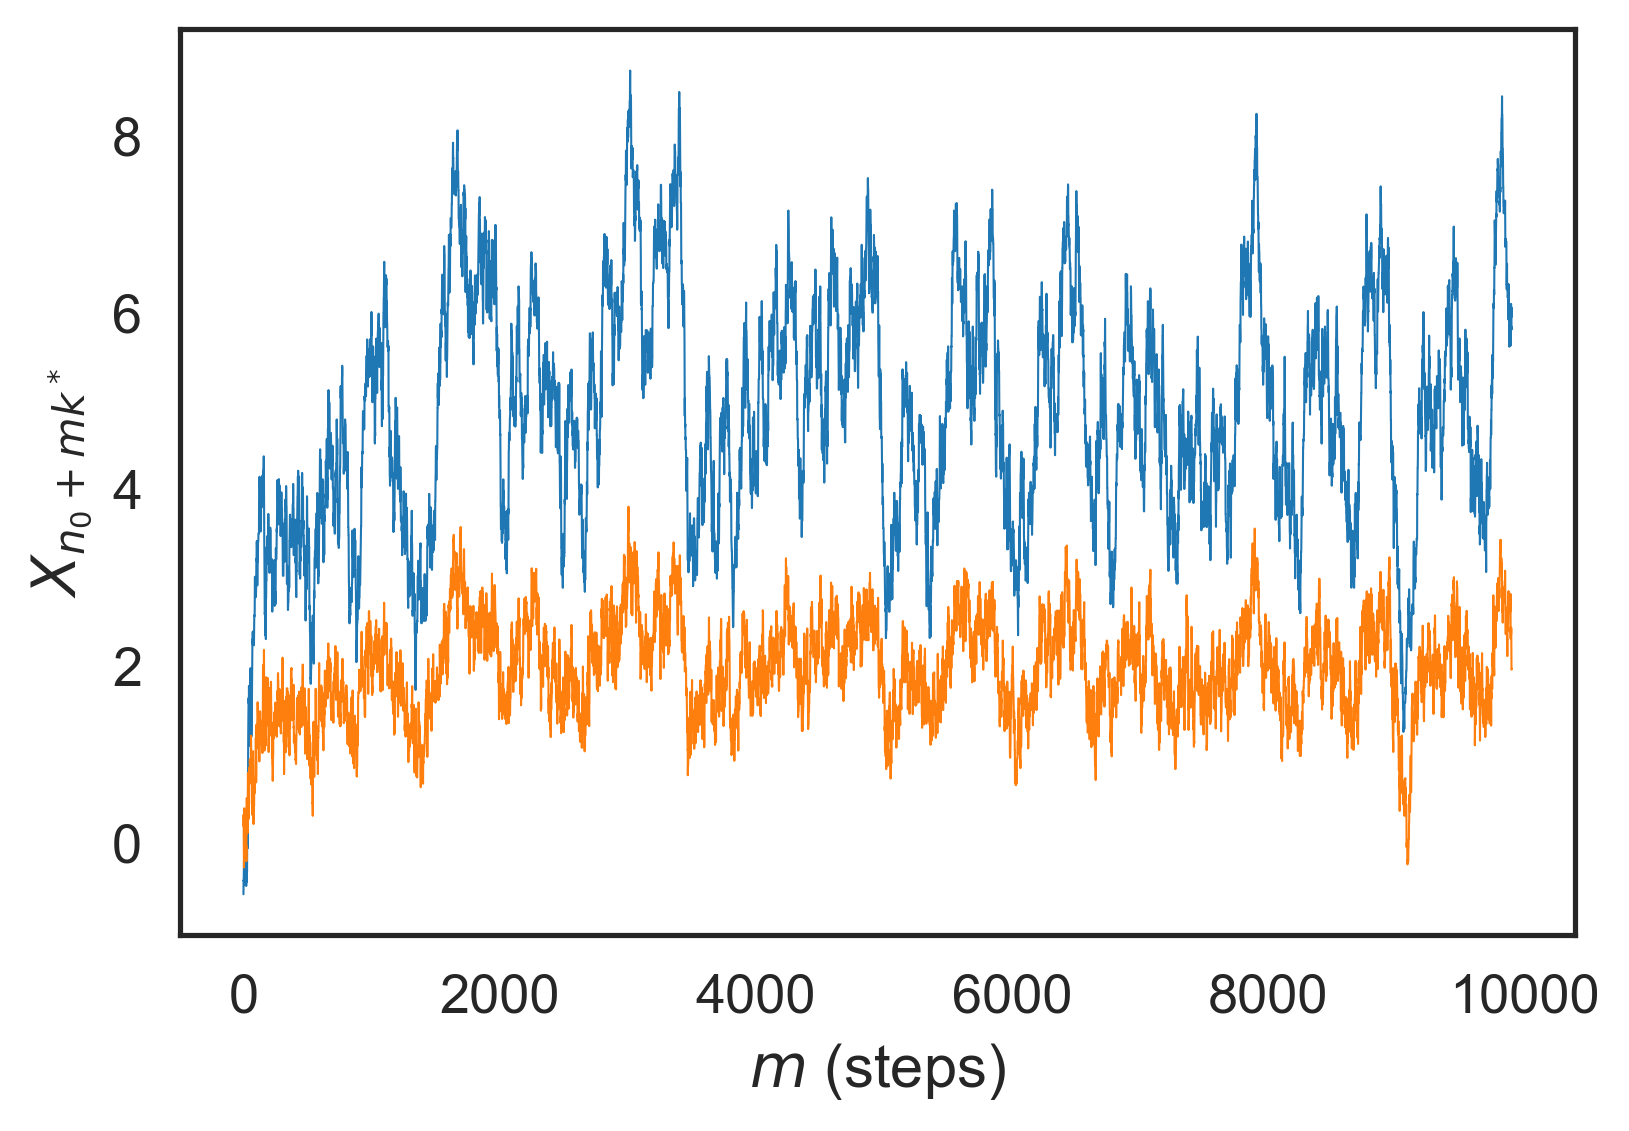

In [23]:
fig, ax = plt.subplots()
ax.plot(X_rest, lw=0.5)
ax.set_xlabel('$m$ (steps)')
ax.set_ylabel('$X_{n_0+m k^*}$');

## Questions

+ For the case shown:
    - find the $\sigma$ that gives you an acceptance rate of about $0.25$.
    - find how many samples $n_b$ you need to burn to get over the transient (if any).
    - find how many samples $k^*$ you need to drop in between to drive the autocorrelation down to almost zero.

# Why Does Metropolis Work?

Well, it works because it gives us a Markov chain with the desired equilibrium distribution.
That is, a chain that has an invariant distribution of our choice that it is also ergodic.

To show that $\pi(x)$ is the invariant distribution of the Metropolis Markov chain, we will show that the latter satisfies the detailed balance condition.
To this end, we need the transition kernel of the chain.
The transition kernel $K(x,x')$ gives the probability that the Metropolis chain moves from $x$ to $x'$.
It is:
$$
K(x,x') = T(x,x')\alpha(x,x') + (1 - r(x))\delta(x' - x),
$$
where $T(x,x')$ is the transition kernel of the proposal distribution,
$$
\alpha(x,x') = \min\left\{1, \frac{h(x')}{h(x)}\right\}
$$
is the acceptance ratio,
$$
r(x) = \int T(x, y)\alpha(x, y)dy,
$$
is the probability of accepting any move, i.e., $1 - r(x)$ is the probability of not accepting the move, and $\delta(x-x')$ is the Dirac delta centered at $x'$.

Let's prove that the detailed balance holds for this transition kernel.
For $x = x'$ the equation holds trivially (even though we would have to interpret it slightly differntly to be 100\% rigorous).
For $x\not x'$, we have:
$$
\begin{array}{ccc}
\pi(x) K(x, x') &=& \frac{h(x)}{Z} T(x,x')\alpha(x,x') \\
&=& \frac{h(x)}{Z}T(x,x')\min\left\{1, \frac{h(x')}{h(x)}\right\}\\
&=& \frac{h(x')}{h(x')}\frac{h(x)}{Z}T(x,x')\min\left\{1, \frac{h(x')}{h(x)}\right\}\\
&=& \frac{h(x')}{Z}T(x,x')\min\left\{\frac{h(x)}{h(x')},\frac{h(x)}{h(x')}\cdot\frac{h(x')}{h(x)}\right\}\\
&=& \pi(x')T(x,x')\min\left\{\frac{h(x)}{h(x')},1\right\}\\
&=& \pi(x')T(x,x')\alpha(x',x)\\
&=& \pi(x')T(x', x)\alpha(x',x)\\
&=& \pi(x')K(x',x),
\end{array}
$$
where we also made use of the symmetry of the proposl $T(x,x') = T(x',x)$.

# Application to Bayesian Inverse Problems

Let us reintroduce everything we had before:

+ $x\in\mathcal{X}\in\mathbb{R}^d$ are the unknown parameters.
+ $y\in\mathcal{Y}\in\mathbb{R}^m$ are the experimental measurements.
+ $f:\mathcal{X}\rightarrow \mathcal{Y}$ is your model.

For the Bayesian approach to inverse problems we need two ingredients:

+ A *prior* probability density for $x$, $p(x)$.

+ A *likelihood model* $p(y|x, f)$.
Typically the form of the likelihood model is:
$$
p(y|x, f) = p(y|f(x)),
$$
and the most common choice is, of course, the Gaussian:
$$
p(y|x,f,\sigma^2) = \mathcal{N}\left(y|f(x), \sigma^2I\right).
$$
Of course, we would like to estimate $\sigma^2$ also.
For this reason, we need to introduce a prior probability density $p(\sigma)$ as well.

**Note:** Remember that the likelihood model is your choice and it should reflect what you know about the noise process.

Let's assume that we have the Gaussian likelihood.
All we need to do now is apply the Bayes rule:
$$
p(x, \sigma^2|y, f) \propto p(y|x,f,\sigma^2)p(x)p(\sigma).
$$
That's it!
This is our *posterior state of knowledge* about all the parameters.
Now the only problem is to characterize this probability density.

We can use the Metropolis algorithm to sample from:
$$
\pi(x) = p(x|y, f,\sigma) \propto p(y|x,f,\sigma^2)p(x).
$$
We could also include $\sigma$, but it requires a little bit more work.
We will do it on the next lecture.

# Example 6: The Catalysis Problem Revisited
For the full details of this problem, please see Lectures 19-20.
We will use the following prior:
$$
p(x) = \mathcal{N}(0,\gamma^2I).
$$
Our posterior is (for just $x$) is:
$$
\pi(x) = p(x|y,\sigma) \propto p(y|x,\sigma)p(x) = \mathcal{N}\left(y|f(x),\sigma^2\right)\mathcal{N}(0,\gamma^2I) \propto \exp\left\{-\frac{\parallel y - f(x) \parallel_2^2}{2\sigma^2}-\frac{\parallel x\parallel^2_2}{2\gamma^2}\right\}.
$$
We will fix $\sigma=12, \gamma=100$ (we will discuss their treatment in subsequent lectures).
Let's sample from it using the machinery we developed.

In [24]:
# The data
import pandas as pd
catalysis_data = pd.read_csv('catalysis.csv', index_col=0)

# The experimental data as a matrix
Y = catalysis_data[1:].get_values()

# For making predictions
import scipy.integrate

def A(x):
    """
    Return the matrix of the dynamical system.
    """
    # Scale back to the k's
    k = np.exp(x) / 180.
    res = np.zeros((6,6))
    res[0, 0] = -k[0]
    res[1, 0] = k[0]
    res[1, 1] = -(k[1] + k[3] + k[4])
    res[2, 1] = k[1]
    res[2, 2] = -k[2]
    res[3, 2] = k[2]
    res[4, 1] = k[4]
    res[5, 1] = k[3]
    return res

def g(z, t, x):
    """
    The right hand side of the dynamical system.
    """
    return np.dot(A(x), z)


# The full solution of the dynamical system
def Z(x, t):
    """
    Returns the solution for parameters x at times t.
    """
    # The initial conditions
    z0 = np.array([500., 0., 0., 0., 0., 0.])
    return scipy.integrate.odeint(g, z0, t, args=(x,))

# The times at which we need to make predictions
T = np.linspace(0, 180, 6)

# The log of the posterior:
def log_h_cat(x, sigma, gamma, T, Y):
    tmp = Z(x, T)
    Yp = np.hstack([tmp[:, :2], tmp[:, 3:]])
    tmp1 = np.sum(((Y - Yp) / sigma) ** 2.)
    tmp2 = np.sum((x / gamma) ** 2)
    return -0.5 * (tmp1 + tmp2)

In [25]:
# Any parameters we fix
sigma = 12.
gamma = 100.

# Initialiazation:
x0 = np.random.randn(5)
# Parameters of the proposal:
sigma_prop = .1
# Number of steps:
n = 10000

# Start sampling
X, acceptance_rate = rwmetropolis(x0, log_h_cat, n, sigma_prop, args=(sigma, gamma, T, Y))

print 'Acceptance rate: %1.2f' % acceptance_rate

Acceptance rate: 0.19


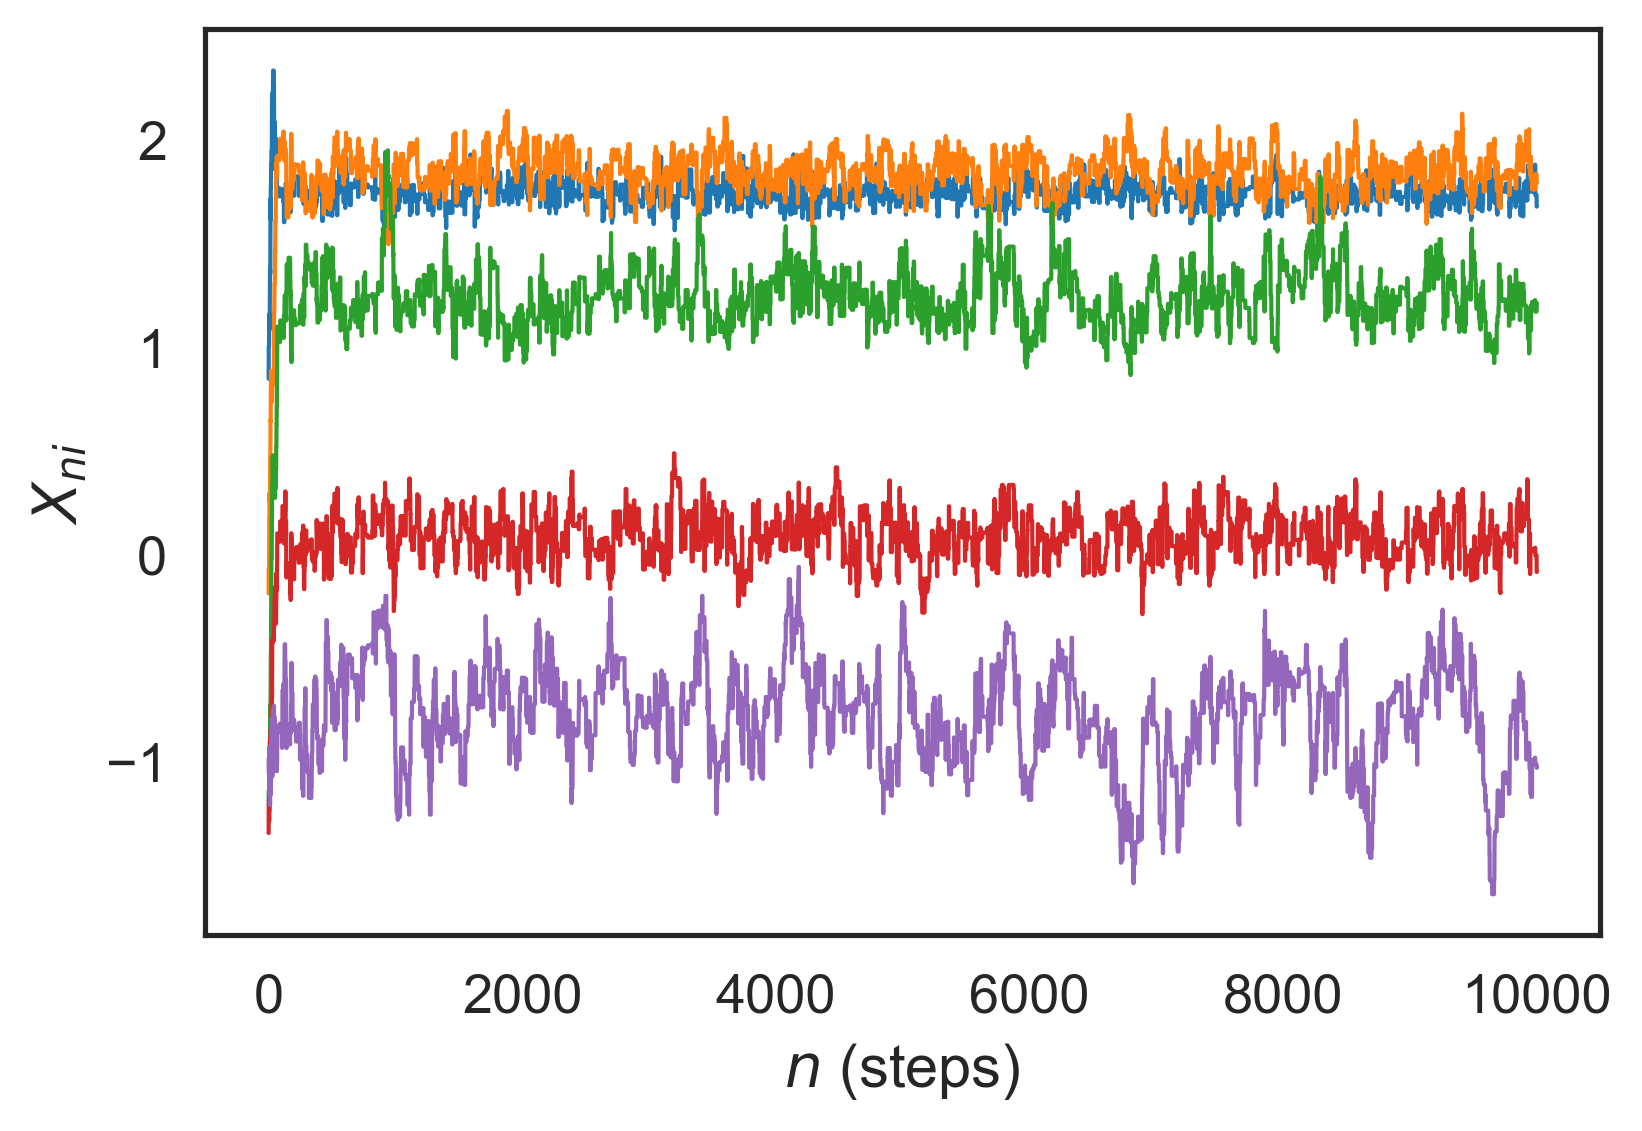

In [26]:
fig, ax = plt.subplots()
ax.plot(range(n + 1), X, lw=1)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$X_{ni}$');

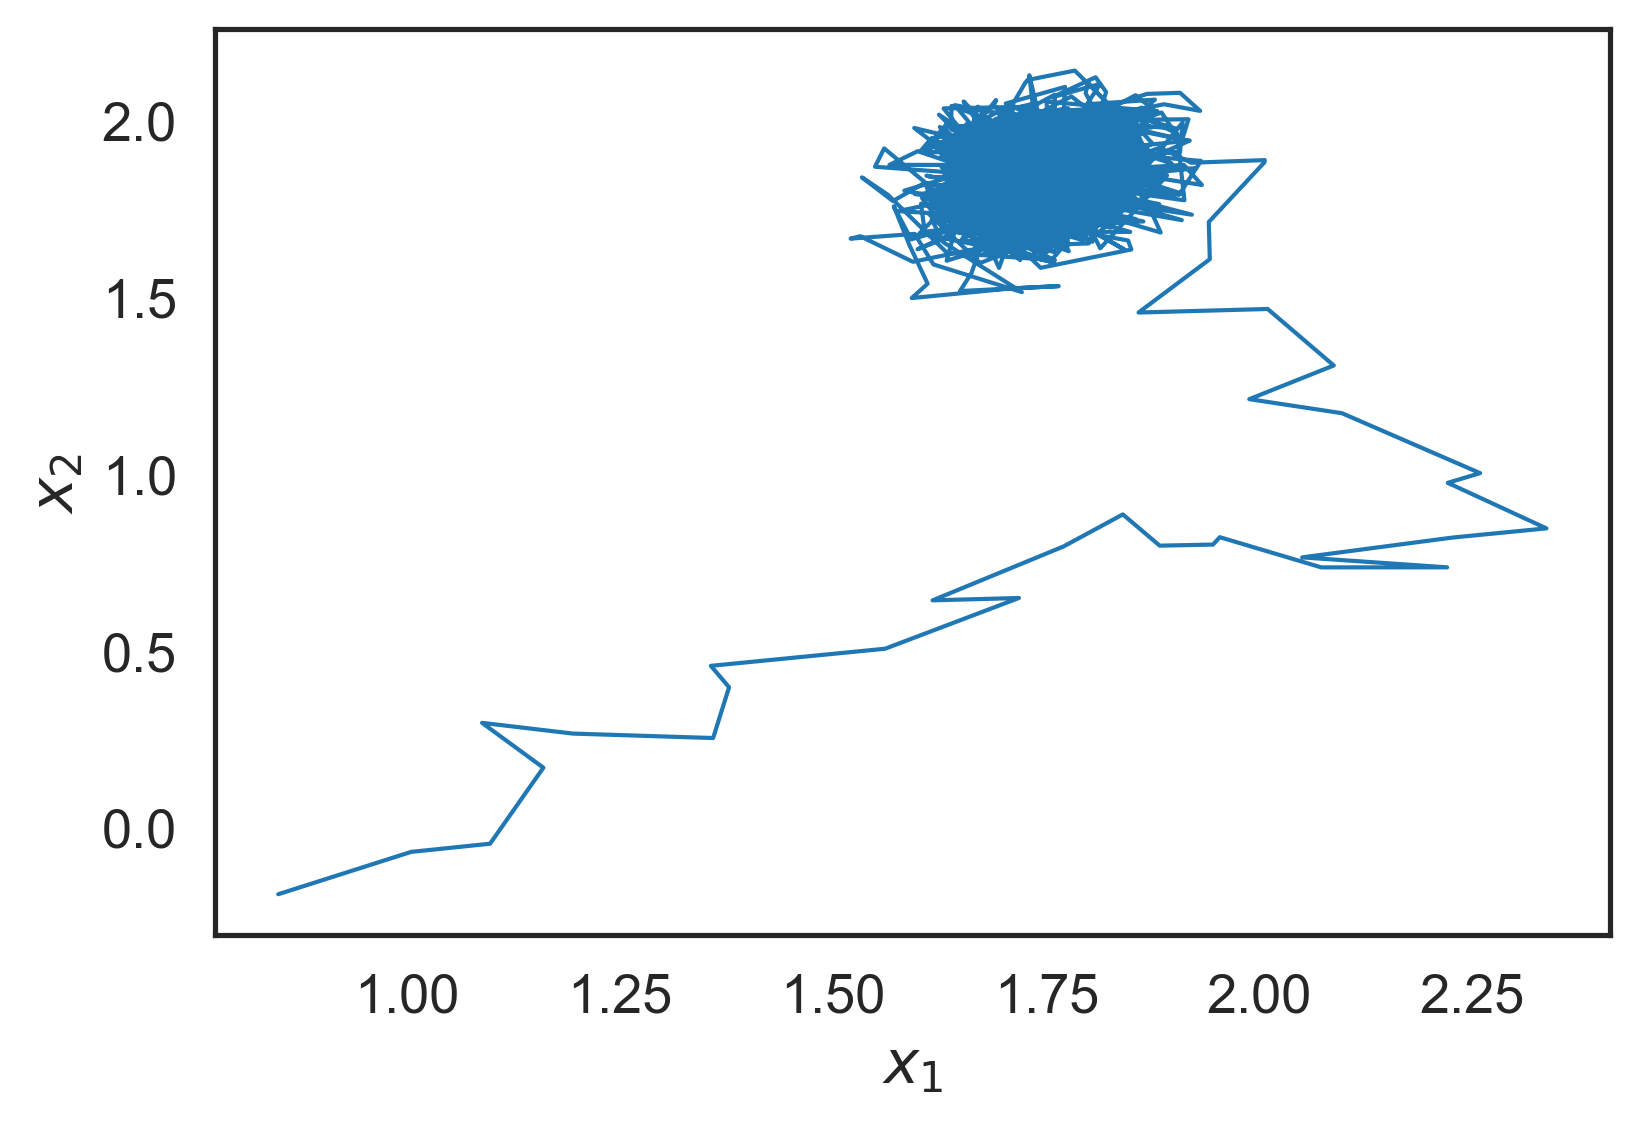

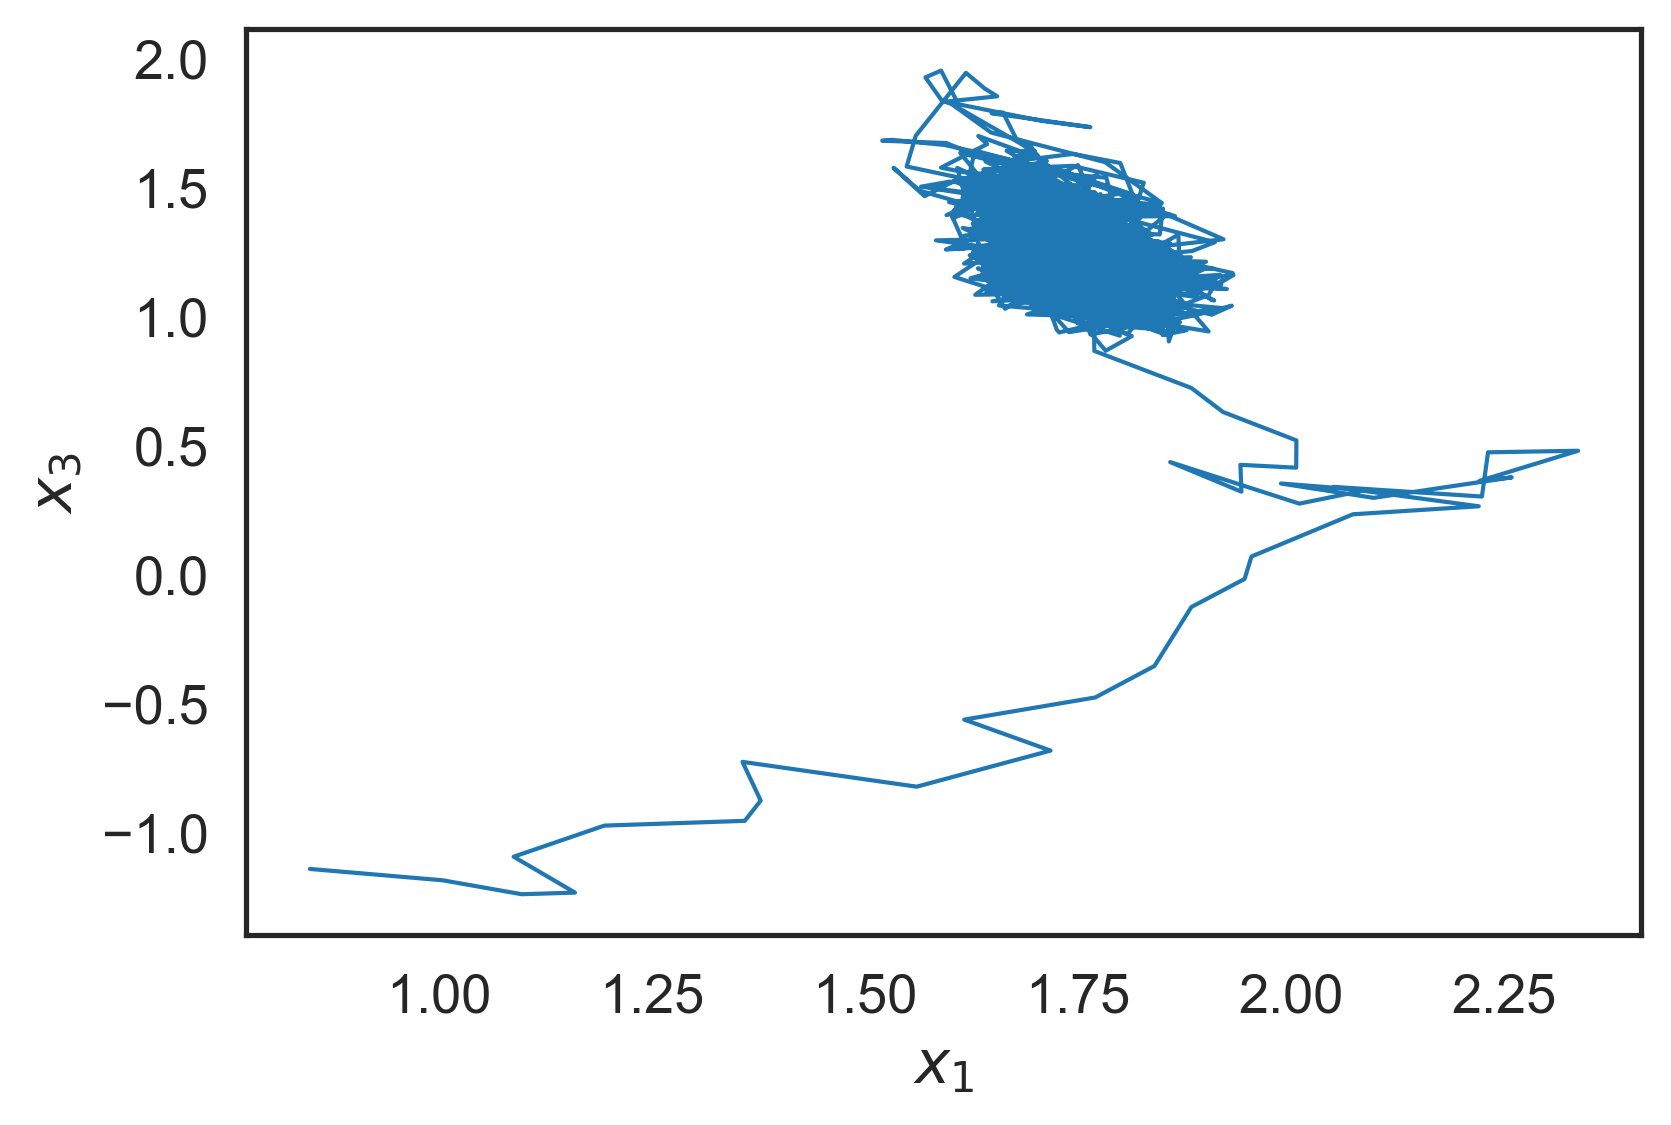

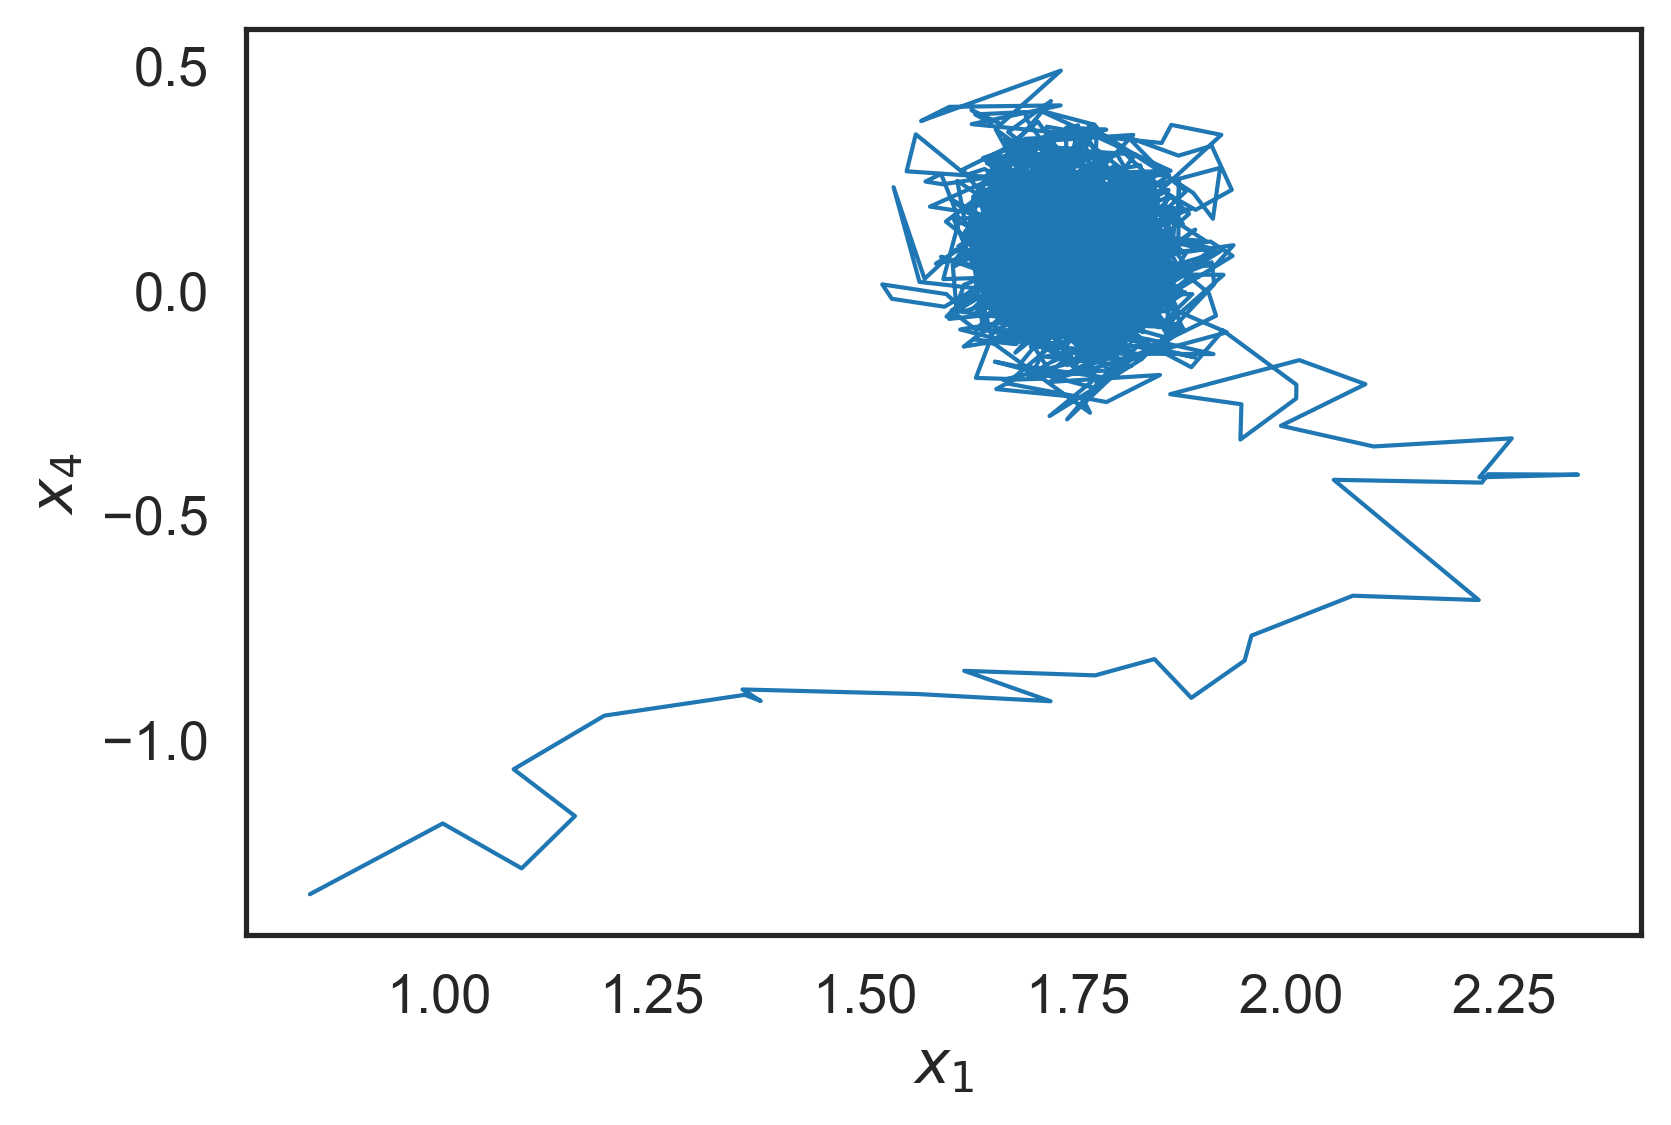

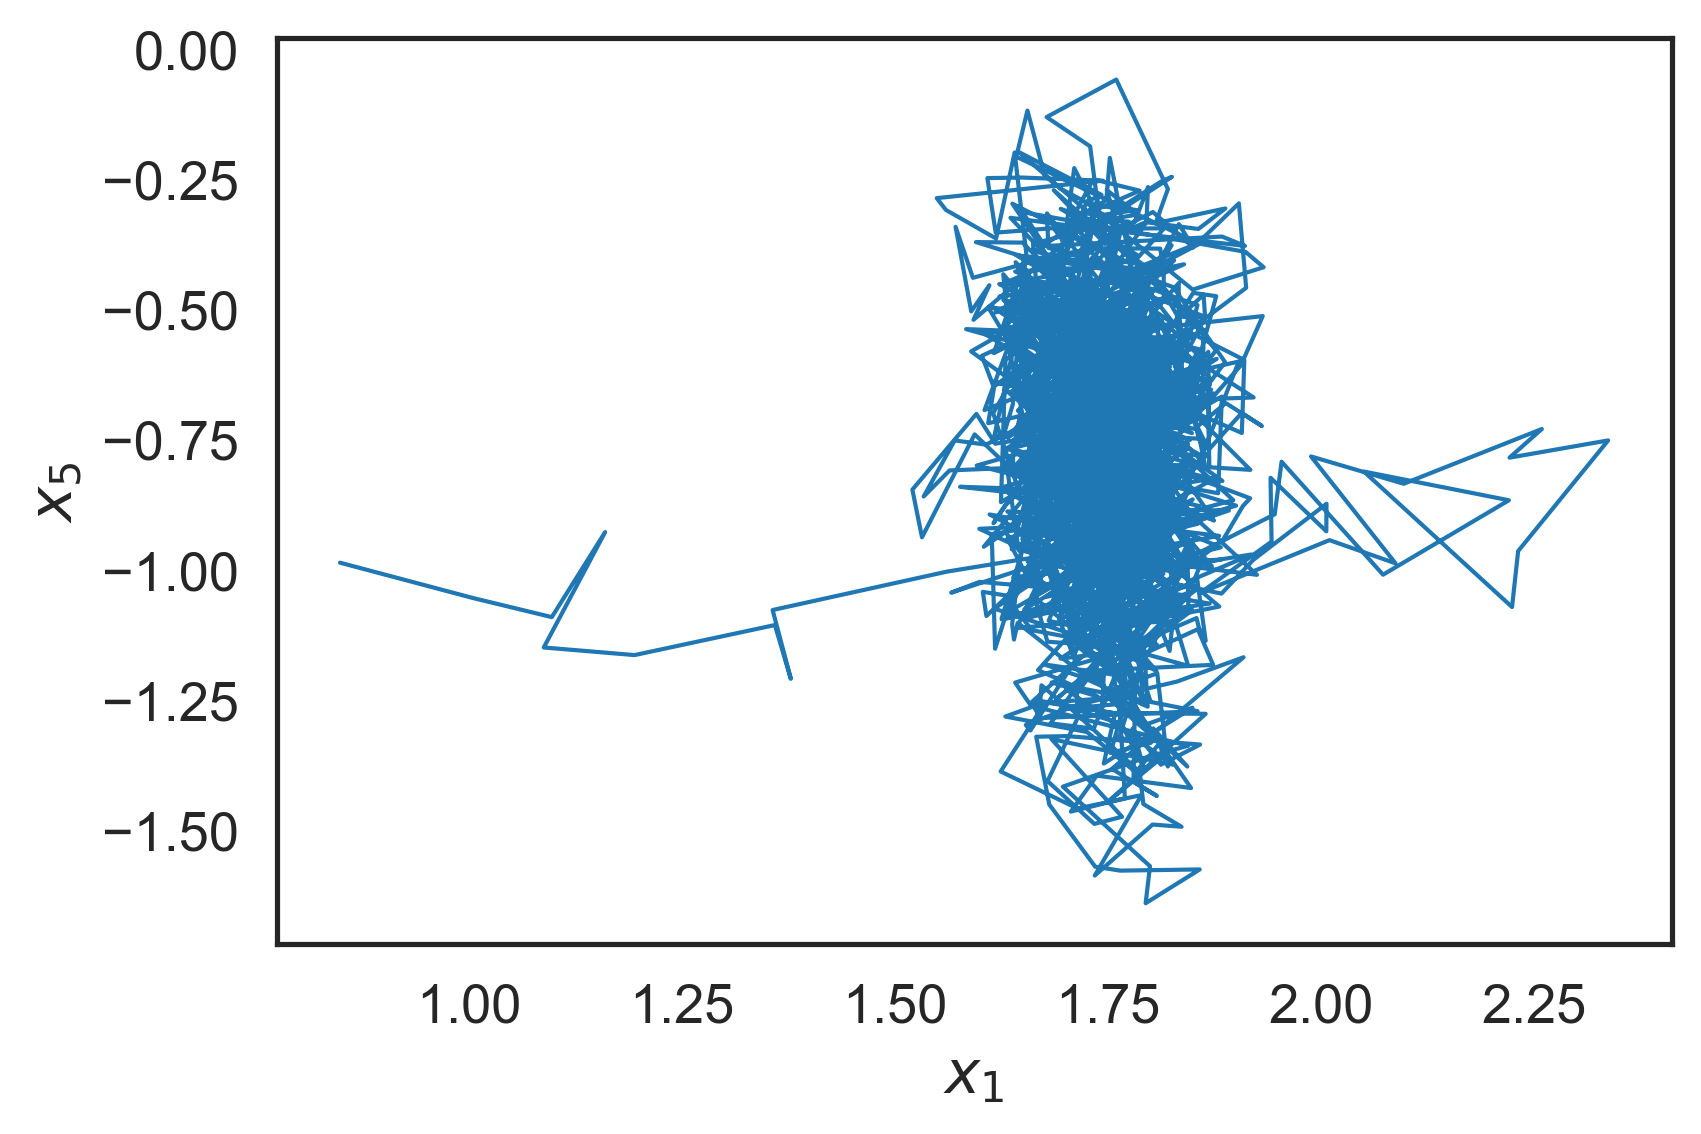

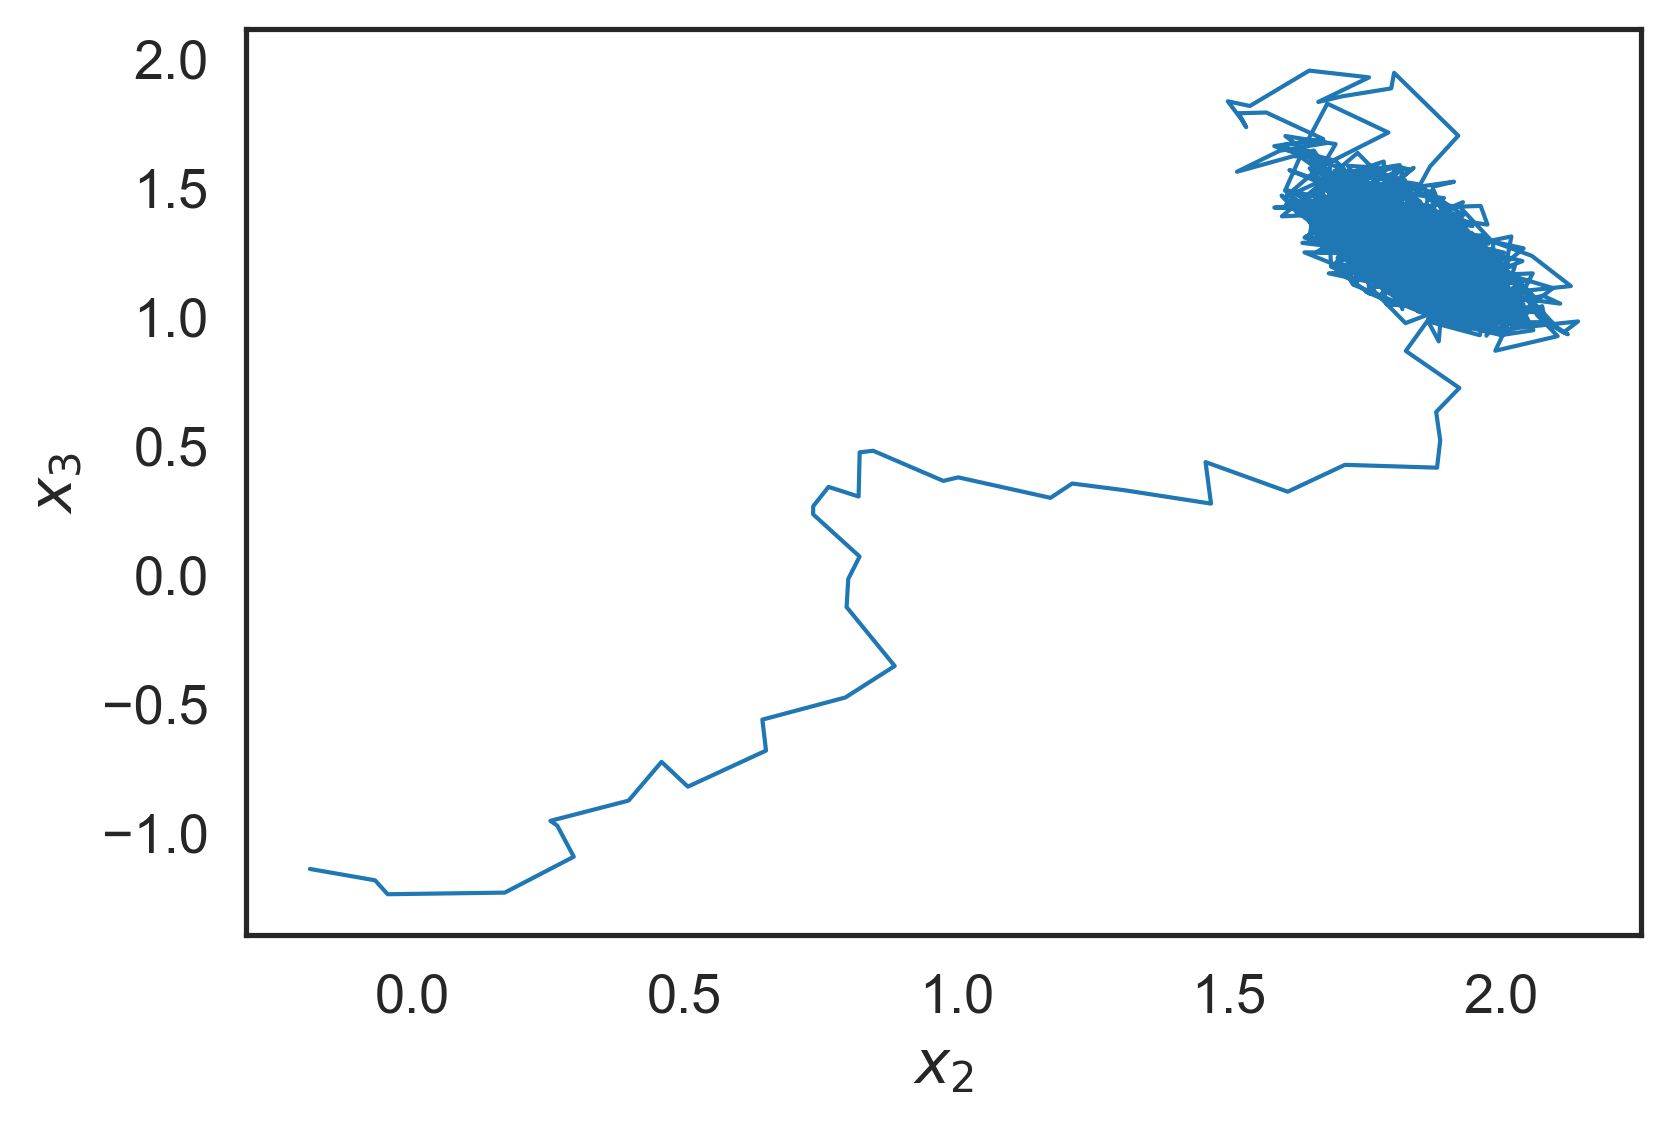

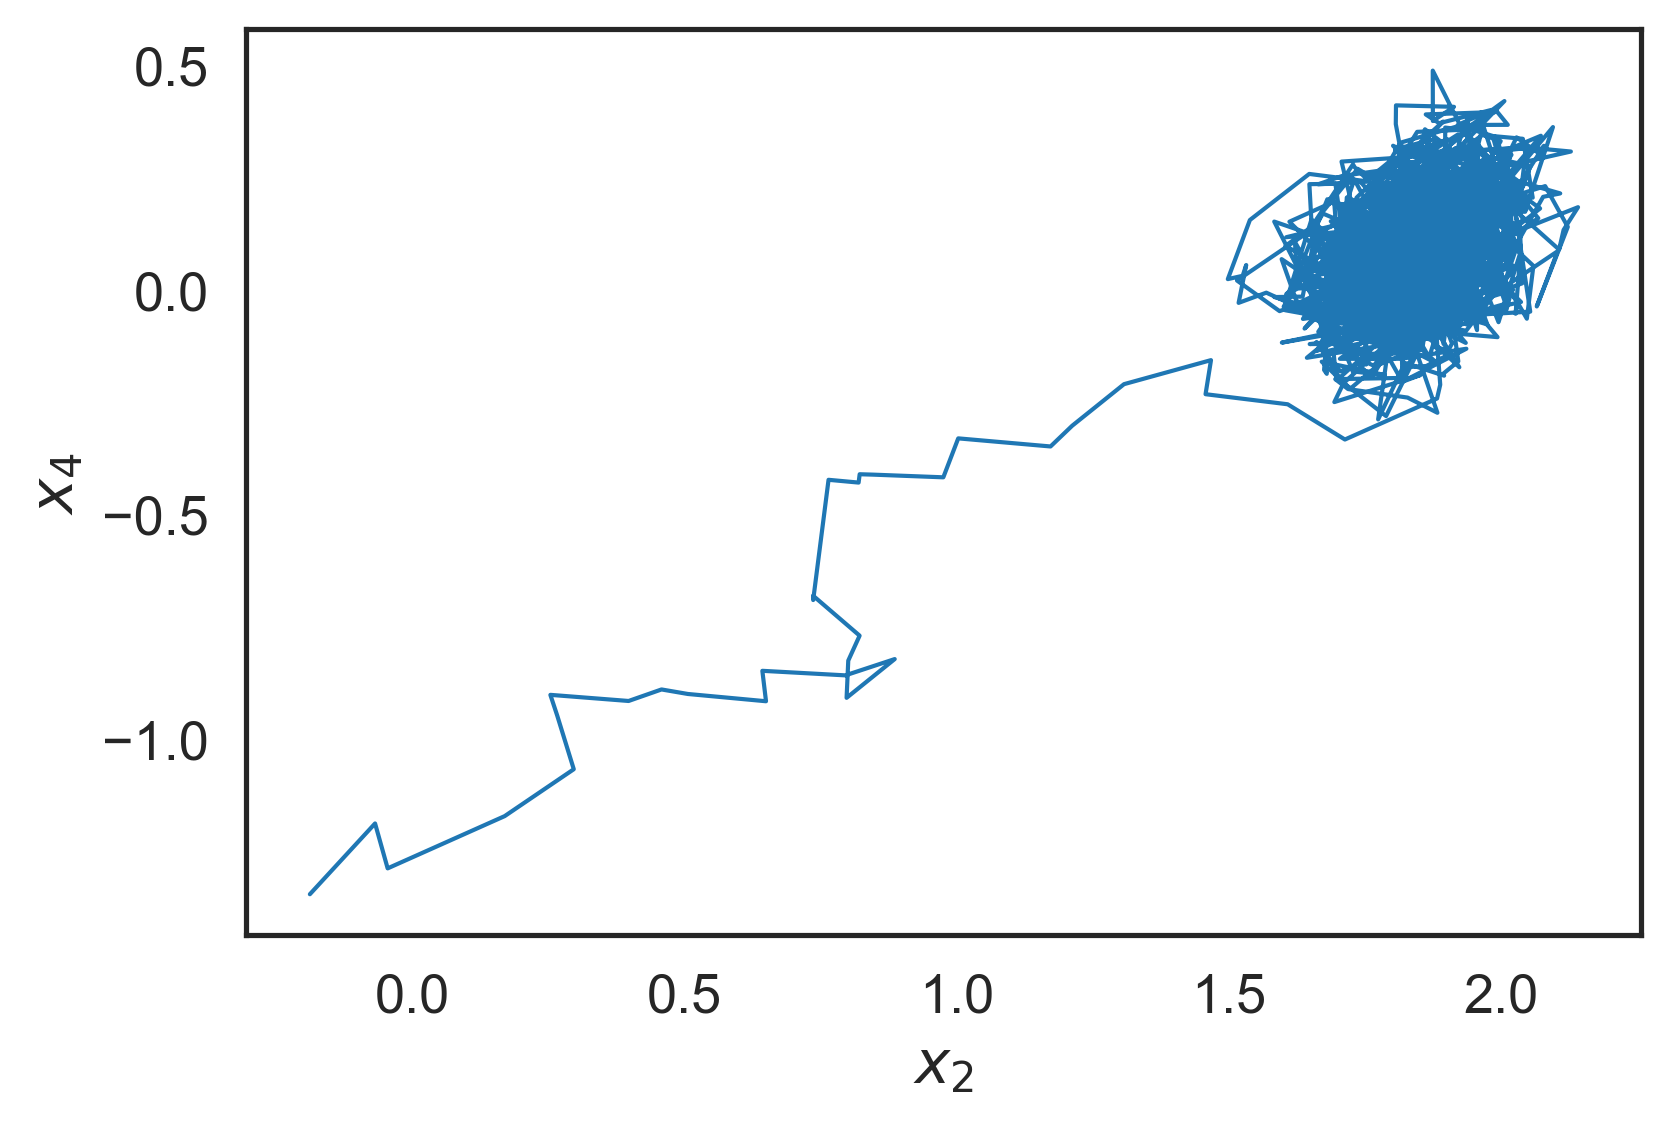

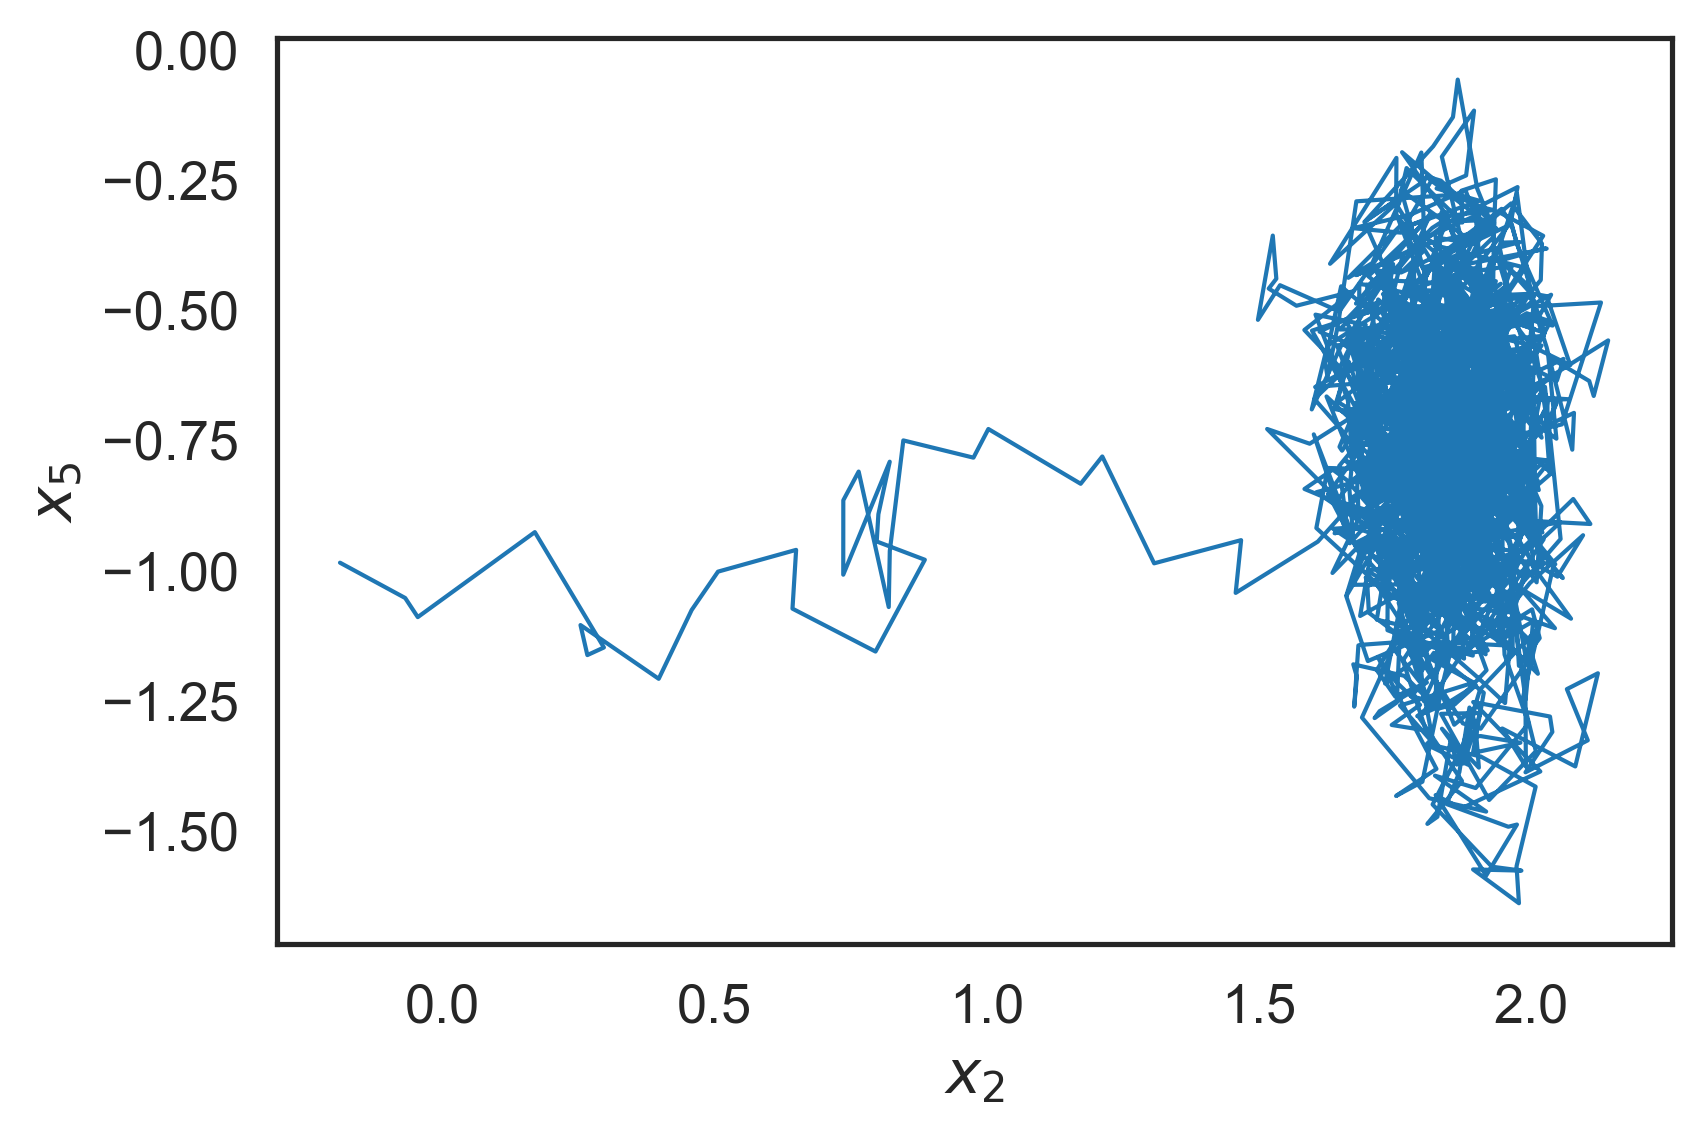

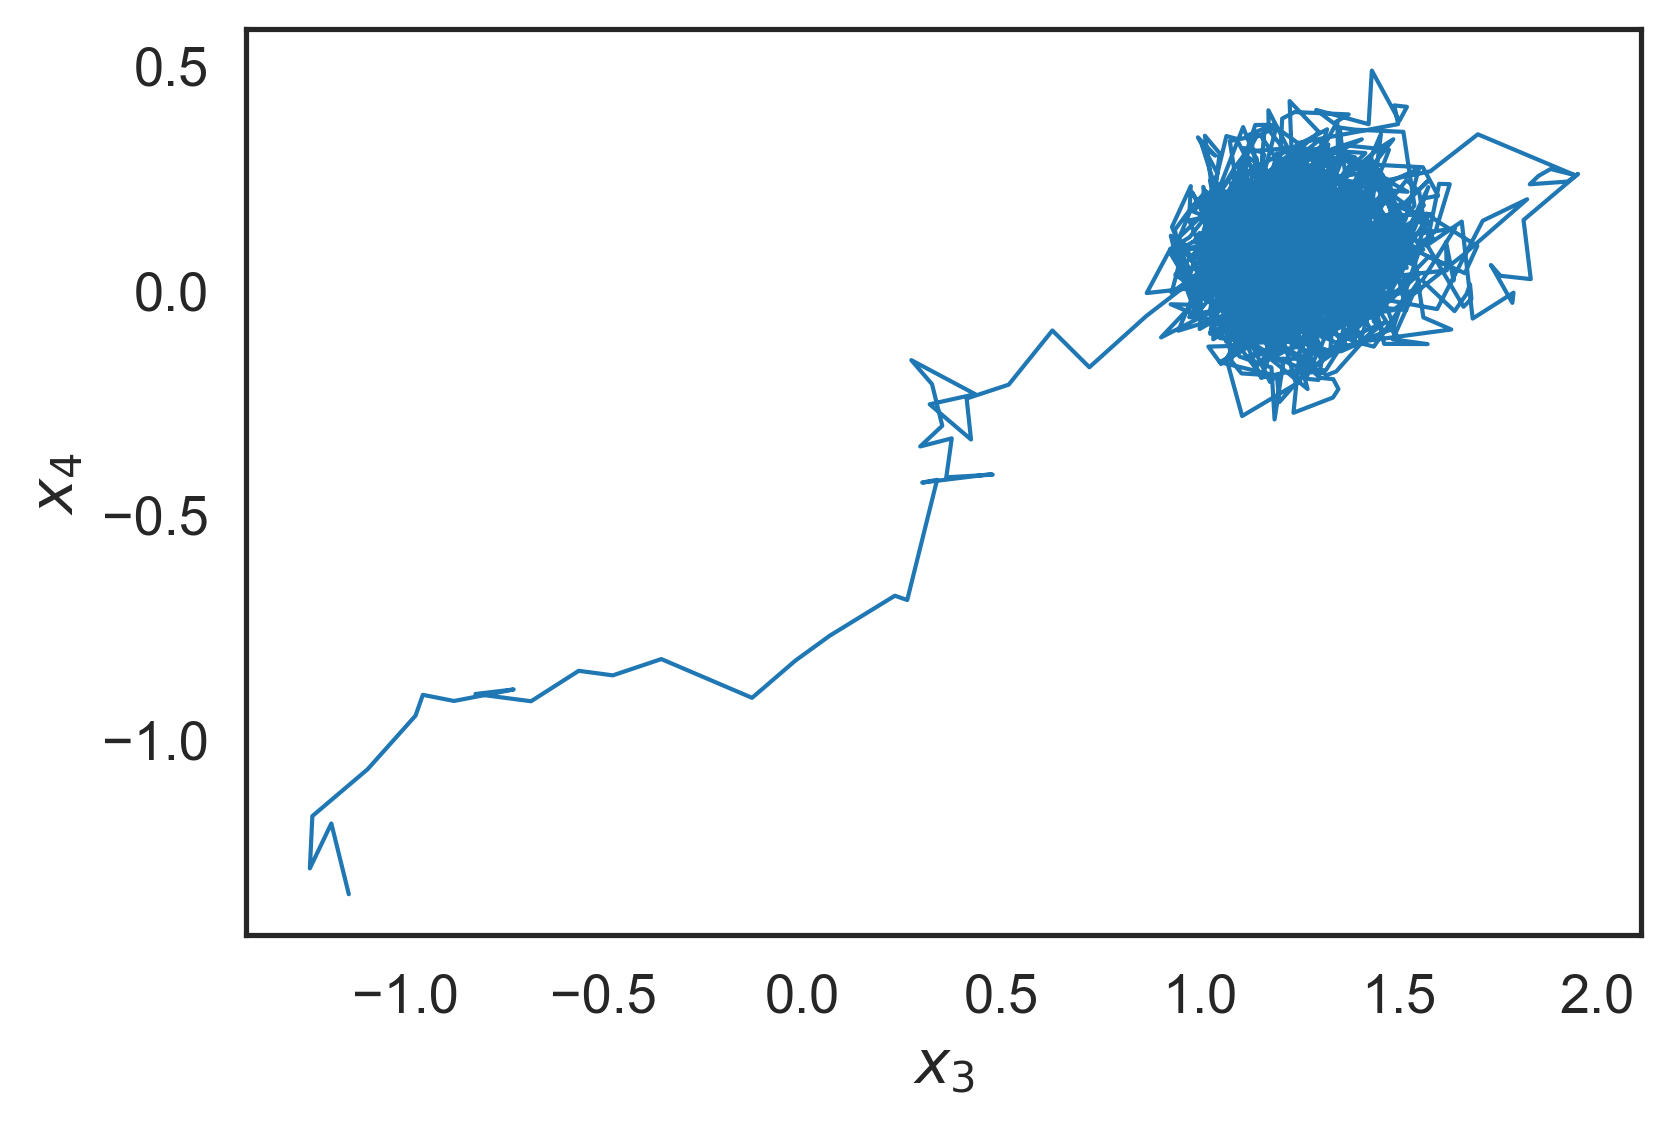

In [27]:
# Draw all pairwise scatter plots
for i in range(X.shape[1]):
    for j in range(i + 1, X.shape[1]):
        fig, ax = plt.subplots()
        ax.plot(X[:, i], X[:, j], lw=1)
        ax.set_xlabel('$x_{%d}$' % (i + 1))
        ax.set_ylabel('$x_{%d}$' % (j + 1));

In [28]:
# How many samples do you want to burn?
burn = 200
# How many samples do you want to throw in between?
thin = 100 # Keep one every ten samples (k*)
# Here are the remaining samples:
X_rest = X[burn::thin]
for i in range(X_rest.shape[1]):
    fig, ax = plt.subplots()
    ax.acorr(X_rest[:, 0], detrend=plt.mlab.detrend_mean, maxlags=200)
    ax.set_xlim(0, 200)
    ax.set_ylabel(r'$R_{%d}(%d \times k)$ (Autocorrelation)' % (i + 1, thin))
    ax.set_xlabel(r'$k$ ($%d \times$ lag)' % thin);

ValueError: maglags must be None or strictly positive < 99

In [ ]:
fig, ax = plt.subplots()
ax.plot(X_rest, lw=0.5)
ax.set_xlabel('$m$ (steps)')
ax.set_ylabel('$X_{n_0+m k^*}$');

In [ ]:
# Now let's do all the pairwise scatter plots for the x-s.
df = pd.DataFrame(X_rest, columns=['$x_{%d}$' % (i + 1) for i in range(X_rest.shape[1])])
gg = sns.PairGrid(df, diag_sharey=False)
gg.map_lower(sns.kdeplot)
gg.map_upper(plt.scatter)
gg.map_diag(sns.kdeplot, lw=3);

In [ ]:
# Now let's transform back to our k's and repeat the procedure
K_rest = np.exp(X_rest) / 180.
df = pd.DataFrame(K_rest, columns=['$k_{%d}$' % (i + 1) for i in range(X_rest.shape[1])])
gg = sns.PairGrid(df, diag_sharey=False)
gg.map_lower(sns.kdeplot)
gg.map_upper(plt.scatter)
gg.map_diag(sns.kdeplot, lw=3);

In [ ]:
# Now, let us compute the statistics of the response.
# Note that what we are doing here is a little bit stupid.
# With better book-keeping we could avoid resolving the dynamical system at every sample.
# We will see how we can exploit packages like pymc to do the book-keeping for us.
t = np.linspace(0, 180, 200)
Y_rest = np.ndarray((X_rest.shape[0], 200, 6))
for i in range(X_rest.shape[0]):
    Y_rest[i, :, :] = Z(X_rest[i, :], t)

In [ ]:
# Now we can do all sorts of statistics:
Y_median = np.median(Y_rest, axis=0)
# Predictive lower bound - Remove/Add the last term if you only want epistemic uncertainty
Y_lower = np.percentile(Y_rest, 2.5, axis=0) #- 1.96 * sigma
# Predictive upper bound - Remove/Add the last term if you only want epistemic uncertainty
Y_upper = np.percentile(Y_rest, 97.5, axis=0) #+ 1.96 * sigma

In [ ]:
# Let's visualize the uncertainty about the response using the MCMC samples
fig, ax = plt.subplots(figsize=(10, 10))
catalysis_data.plot(ax=ax, style='s')
ax.plot(t, Y_median[:, 0], color=sns.color_palette()[0], label='Model NO3-')
ax.plot(t, Y_median[:, 1], color=sns.color_palette()[1], label='Model NO2-')
ax.plot(t, Y_median[:, 2], color=sns.color_palette()[5], label='Model X')
ax.plot(t, Y_median[:, 3], color=sns.color_palette()[2], label='Model N2')
ax.plot(t, Y_median[:, 4], color=sns.color_palette()[3], label='Model NH3')
ax.plot(t, Y_median[:, 5], color=sns.color_palette()[4], label='Model N2O')
ax.fill_between(t, Y_lower[:, 0], Y_upper[:, 0], color=sns.color_palette()[0], alpha=0.25)
ax.fill_between(t, Y_lower[:, 1], Y_upper[:, 1], color=sns.color_palette()[1], alpha=0.25)
ax.fill_between(t, Y_lower[:, 2], Y_upper[:, 2], color=sns.color_palette()[5], alpha=0.25)
ax.fill_between(t, Y_lower[:, 3], Y_upper[:, 3], color=sns.color_palette()[2], alpha=0.25)
ax.fill_between(t, Y_lower[:, 4], Y_upper[:, 4], color=sns.color_palette()[3], alpha=0.25)
ax.fill_between(t, Y_lower[:, 5], Y_upper[:, 5], color=sns.color_palette()[4], alpha=0.25);

## Questions

+ For the case shown:
    - find the ``sigma_prop`` that gives you an acceptance rate of about $0.25$.
    - find how many samples $n_b$ you need to burn to get over the transient (if any).
    - find how many samples $k^*$ you need to drop in between to drive the autocorrelation down to almost zero.